In [2]:
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import pacf
import xgboost as xgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit

In [3]:
X_train = pd.read_csv('../challenge_data/X_train.csv')
Y_train = pd.read_csv('../challenge_data/Y_train.csv')
X_test = pd.read_csv('../challenge_data/X_test.csv')

In [4]:
X_train.head()

ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  \
0  1054     206      FR        0.210099       -0.427458       -0.606523   
1  2049     501      FR       -0.022399       -1.003452       -0.022063   
2  1924     687      FR        1.395035        1.978665        1.021305   
3   297     720      DE       -0.983324       -0.849198       -0.839586   
4  1101     818      FR        0.143807       -0.617038       -0.924990   

   FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  ...  \
0        0.606523            NaN       0.692860            NaN  ...   
1        0.022063      -0.573520      -1.130838       0.573520  ...   
2       -1.021305      -0.622021      -1.682587       0.622021  ...   
3        0.839586      -0.270870       0.563230       0.270870  ...   
4        0.924990            NaN       0.990324            NaN  ...   

   FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
0         -0.444661 -0.172680 -0.556356 -0.790823 -0.283160 -1.069070   
1         -1.183194 -1.240300 -0.770457  1.522331  0.828412  0.437419   
2          1.947273 -0.480700 -0.313338  0.431134  0.487608  0.684884   
3         -0.976974 -1.114838 -0.507570 -0.499409 -0.236249  0.350938   
4         -0.526267 -0.541465 -0.424550 -1.088158 -1.011560  0.614338   

    FR_TEMP   GAS_RET  COAL_RET  CARBON_RET  
0 -0.063404  0.339041  0.124552   -0.002445  
1  1.831241 -0.659091  0.047114   -0.490365  
2  0.114836  0.535974  0.743338    0.204952  
3 -0.417514  0.911652 -0.296168    1.073948  
4  0.729495  0.245109  1.526606    2.614378  

[5 rows x 35 columns]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
bx_train, bx_test, by_train, by_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=88)
br_lr = LinearRegression()

br_x_train_clean, br_x_test_clean = bx_train.fillna(0).drop(['ID', 'DAY_ID', 'COUNTRY'], axis=1), bx_test.fillna(0).drop(['ID', 'DAY_ID', 'COUNTRY'], axis=1)
y_train_clean, y_test_clean = by_train['TARGET'], by_test['TARGET']

br_lr.fit(br_x_train_clean, y_train_clean)

br_test_output = br_lr.predict(br_x_test_clean)

def metric_train(output, test):
    return  spearmanr(output, test).correlation

print('Spearman correlation for the benchmark: {:.1f}%'.format(100 * metric_train(br_test_output, y_test_clean)))
lr_test_output = br_lr.predict(br_x_train_clean)
print(spearmanr(lr_test_output, y_train_clean).correlation)

Spearman correlation for the benchmark: 21.0%
0.26189813889010455


In [6]:

all_features=pd.merge(X_train, Y_train, on='ID', how='left')

In [7]:
quantatitve_data=all_features.drop('COUNTRY',axis=1)

In [8]:
df_fr = all_features[all_features['COUNTRY'] == 'FR'].drop('COUNTRY',axis=1)
df_de = all_features[all_features['COUNTRY'] == 'DE'].drop('COUNTRY',axis=1)

In [9]:
def spearman_corr_with_nan(x, y):
    # Handle categorical data if any
    if x.dtype.name == 'category':
        x = x.cat.codes
    if y.dtype.name == 'category':
        y = y.cat.codes

    # Filter out pairs with NaN in either column
    valid_indices = ~np.isnan(x) & ~np.isnan(y)

    # Calculate correlation if there are valid pairs
    if np.any(valid_indices):
        return spearmanr(x[valid_indices], y[valid_indices]).correlation
    else:
        return np.nan
target_column = 'TARGET'  # Replace with your actual target column name
correlation_coeffs = df_fr.drop(target_column, axis=1).apply(lambda x: spearman_corr_with_nan(x, df_fr[target_column]))
print(correlation_coeffs)

ID                 -0.011895
DAY_ID             -0.009342
DE_CONSUMPTION     -0.051604
FR_CONSUMPTION     -0.020299
DE_FR_EXCHANGE     -0.015005
FR_DE_EXCHANGE      0.015005
DE_NET_EXPORT      -0.085175
FR_NET_EXPORT      -0.008333
DE_NET_IMPORT       0.085175
FR_NET_IMPORT       0.008333
DE_GAS              0.017550
FR_GAS             -0.031254
DE_COAL             0.018754
FR_COAL             0.068084
DE_HYDRO            0.087350
FR_HYDRO            0.071709
DE_NUCLEAR          0.010434
FR_NUCLEAR          0.004077
DE_SOLAR            0.038168
FR_SOLAR            0.007298
DE_WINDPOW         -0.080487
FR_WINDPOW         -0.121530
DE_LIGNITE          0.002197
DE_RESIDUAL_LOAD    0.053790
FR_RESIDUAL_LOAD    0.006008
DE_RAIN            -0.057378
FR_RAIN            -0.028452
DE_WIND            -0.038131
FR_WIND            -0.042187
DE_TEMP            -0.018114
FR_TEMP            -0.048669
GAS_RET             0.148956
COAL_RET            0.057616
CARBON_RET          0.191809
dtype: float64

In [10]:
def spearman_corr_with_nan(x, y):
    # Handle categorical data if any
    if x.dtype.name == 'category':
        x = x.cat.codes
    if y.dtype.name == 'category':
        y = y.cat.codes

    # Filter out pairs with NaN in either column
    valid_indices = ~np.isnan(x) & ~np.isnan(y)

    # Calculate correlation if there are valid pairs
    if np.any(valid_indices):
        return spearmanr(x[valid_indices], y[valid_indices]).correlation
    else:
        return np.nan
target_column = 'TARGET'  # Replace with your actual target column name
correlation_coeffs = df_de.drop(target_column, axis=1).apply(lambda x: spearman_corr_with_nan(x, df_de[target_column]))
print(correlation_coeffs)

ID                 -0.009298
DAY_ID              0.008882
DE_CONSUMPTION     -0.071736
FR_CONSUMPTION     -0.033651
DE_FR_EXCHANGE     -0.094402
FR_DE_EXCHANGE      0.094402
DE_NET_EXPORT      -0.306204
FR_NET_EXPORT      -0.004076
DE_NET_IMPORT       0.306204
FR_NET_IMPORT       0.004076
DE_GAS              0.253410
FR_GAS              0.072784
DE_COAL             0.142054
FR_COAL             0.032621
DE_HYDRO            0.217900
FR_HYDRO            0.058362
DE_NUCLEAR          0.012366
FR_NUCLEAR         -0.008885
DE_SOLAR            0.021202
FR_SOLAR            0.046483
DE_WINDPOW         -0.300933
FR_WINDPOW         -0.199820
DE_LIGNITE          0.124605
DE_RESIDUAL_LOAD    0.324335
FR_RESIDUAL_LOAD    0.039952
DE_RAIN            -0.012565
FR_RAIN            -0.082353
DE_WIND            -0.162500
FR_WIND            -0.102720
DE_TEMP            -0.024554
FR_TEMP            -0.048525
GAS_RET            -0.015835
COAL_RET           -0.020653
CARBON_RET          0.010366
dtype: float64

In [11]:
def calculate_compounded_price(df, sort_column):
    df_sorted = df.sort_values(by=sort_column)
    compounded_price = df_sorted['TARGET'].cumsum()
    return df_sorted[sort_column], compounded_price

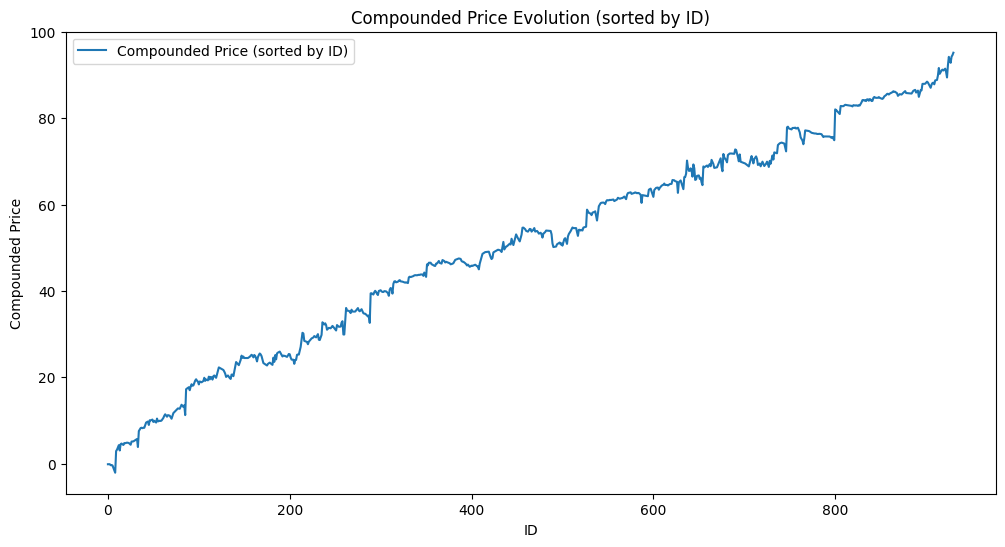

In [12]:
id_sorted, compounded_price_id = calculate_compounded_price(df_de, 'ID')
plt.figure(figsize=(12, 6))
plt.plot(id_sorted, compounded_price_id, label='Compounded Price (sorted by ID)')
plt.xlabel('ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by ID)')
plt.legend()
plt.show()

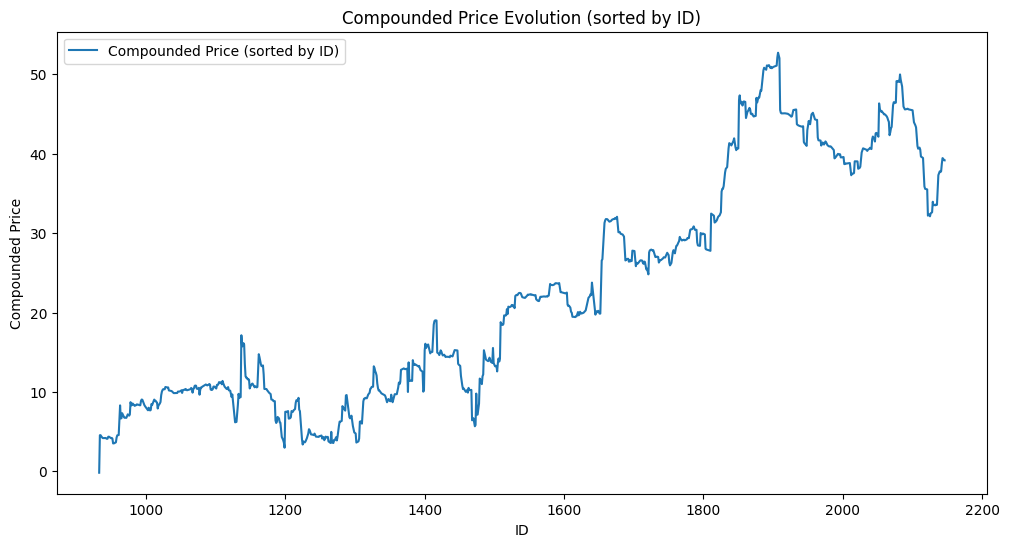

In [13]:
id_sorted, compounded_price_id = calculate_compounded_price(df_fr, 'ID')
plt.figure(figsize=(12, 6))
plt.plot(id_sorted, compounded_price_id, label='Compounded Price (sorted by ID)')
plt.xlabel('ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by ID)')
plt.legend()
plt.show()

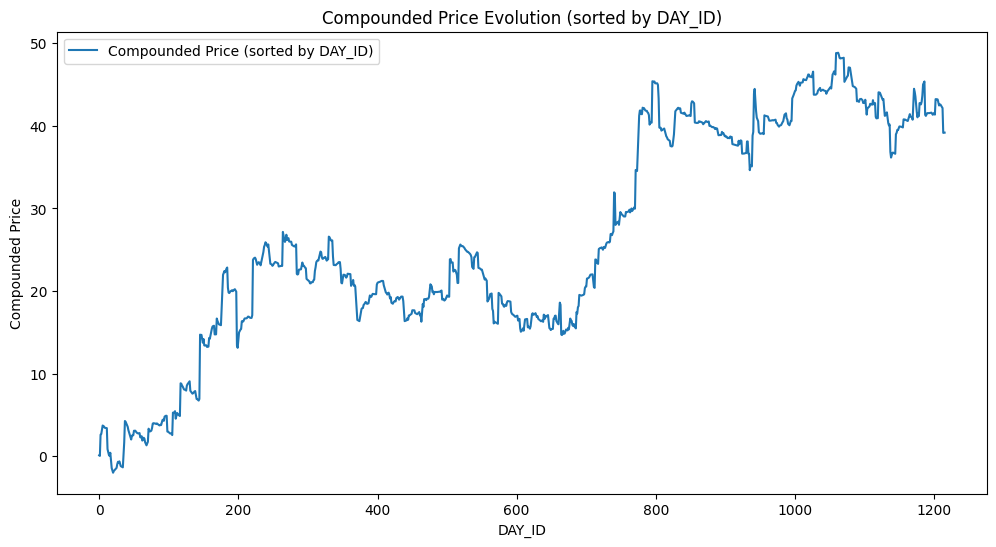

In [14]:
day_id_sorted, compounded_price_day_id = calculate_compounded_price(df_fr, 'DAY_ID')
plt.figure(figsize=(12, 6))
plt.plot(day_id_sorted, compounded_price_day_id, label='Compounded Price (sorted by DAY_ID)')
plt.xlabel('DAY_ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by DAY_ID)')
plt.legend()
plt.show()

In [15]:
window_size = 365  #  can adjust later

df_fr['FR_TEMP_MA_BY_ID'] = df_fr.sort_values(by='ID')['FR_TEMP']
df_de['DE_TEMP_MA_BY_ID'] = df_de.sort_values(by='ID')['DE_TEMP'].rolling(window=window_size).mean()

df_fr['FR_TEMP_MA_BY_DAY_ID'] = df_fr.sort_values(by='DAY_ID')['FR_TEMP'].rolling(window=window_size).mean()
df_de['DE_TEMP_MA_BY_DAY_ID'] = df_de.sort_values(by='DAY_ID')['DE_TEMP'].rolling(window=window_size).mean()

In [16]:

df_fr['FR_TEMP_MA_BY_ID']

0      -0.063404
1       1.831241
2       0.114836
4       0.729495
5       0.472708
          ...   
1483   -0.555211
1486    0.829517
1487   -2.069991
1490         NaN
1492    1.338708
Name: FR_TEMP_MA_BY_ID, Length: 851, dtype: float64

In [17]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)

# Load data and set 'ID' as the index
df = pd.read_csv('../challenge_data/X_train.csv').set_index('ID').sort_index()
y = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('../challenge_data/X_test.csv').set_index('ID')

# Filter data for Germany and France
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]  # Ensure the target dataframe (y) aligns with filtered data
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]  # Same as above for France

# Merging Training and Testing Data
# Ensure that both df and true_test are indeed DataFrames
if isinstance(df, pd.DataFrame) and isinstance(true_test, pd.DataFrame):
    full = pd.concat([df, true_test]).sort_index()
else:
    print("One of the objects is not a DataFrame.")

full_de = full[full['COUNTRY'] == 'DE']
full_fr = full[full['COUNTRY'] == 'FR']
# Data Normalization for Germany
full_de_norm = full_de.drop(['DAY_ID', 'COUNTRY'], axis=1)
full_de_norm = (full_de_norm - full_de_norm.mean()) / full_de_norm.std()
# Data Normalization for France
full_fr_norm = full_fr.drop(['DAY_ID', 'COUNTRY'], axis=1)
full_fr_norm = (full_fr_norm - full_fr_norm.mean()) / full_fr_norm.std()

<Figure size 640x480 with 0 Axes>

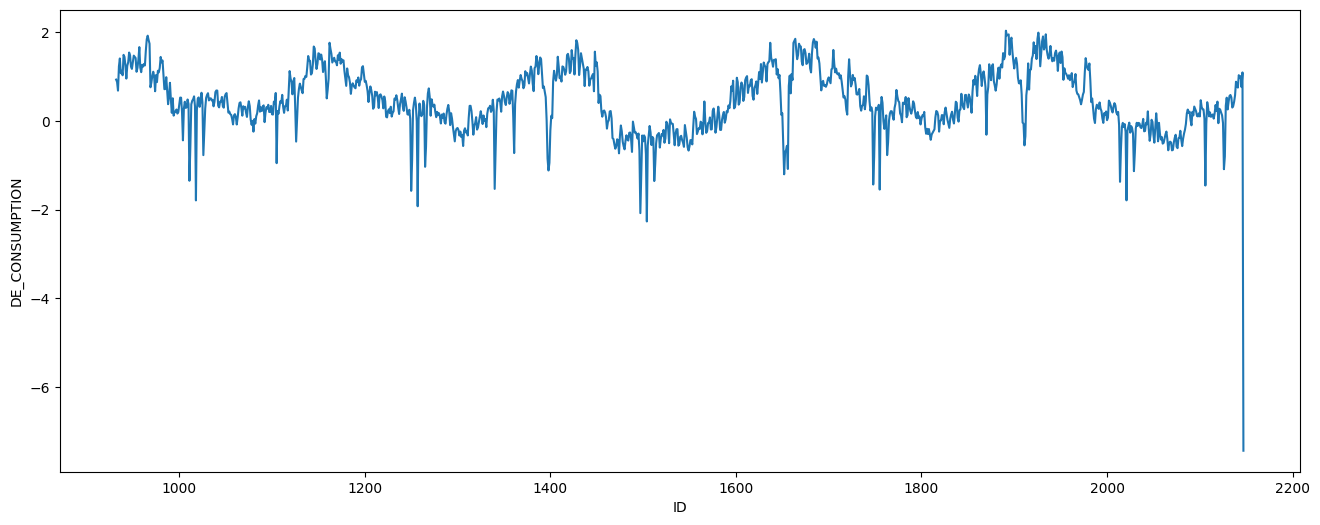

<Figure size 640x480 with 0 Axes>

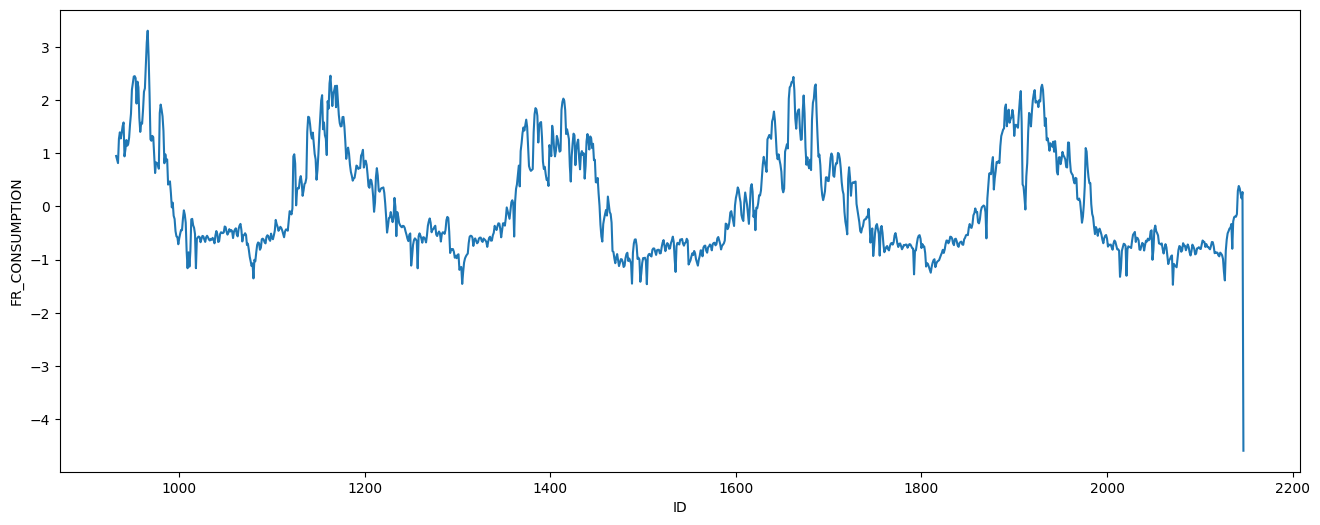

<Figure size 640x480 with 0 Axes>

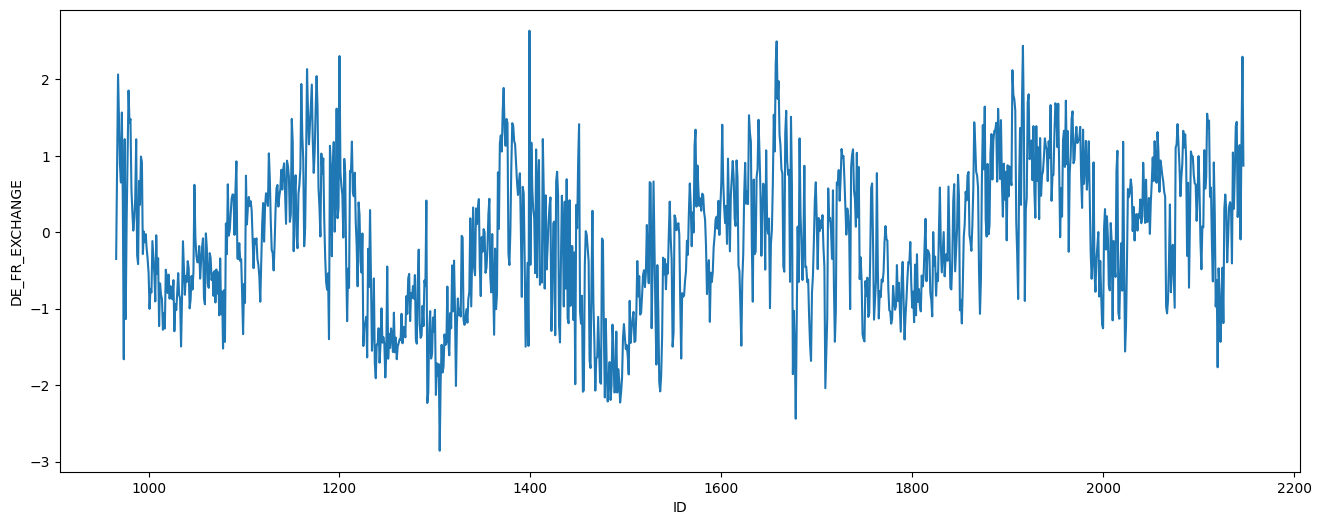

<Figure size 640x480 with 0 Axes>

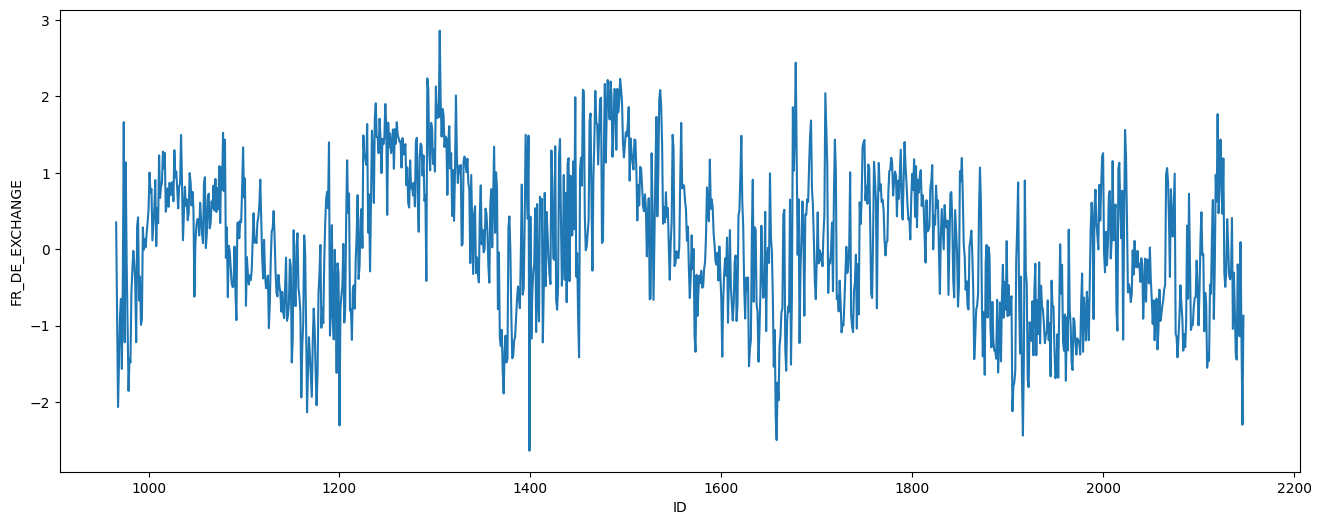

<Figure size 640x480 with 0 Axes>

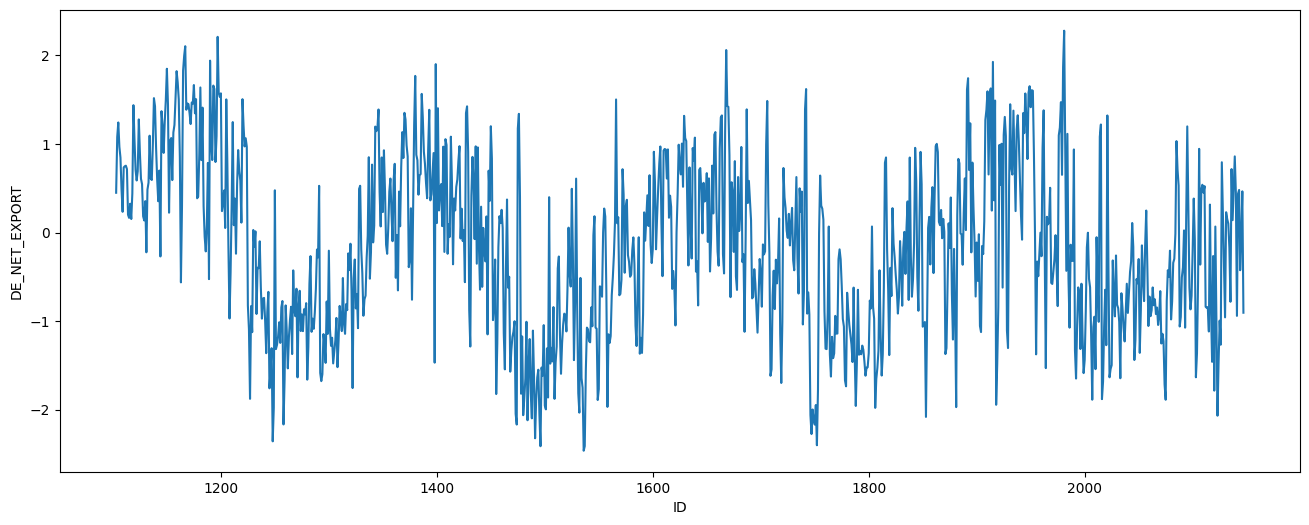

<Figure size 640x480 with 0 Axes>

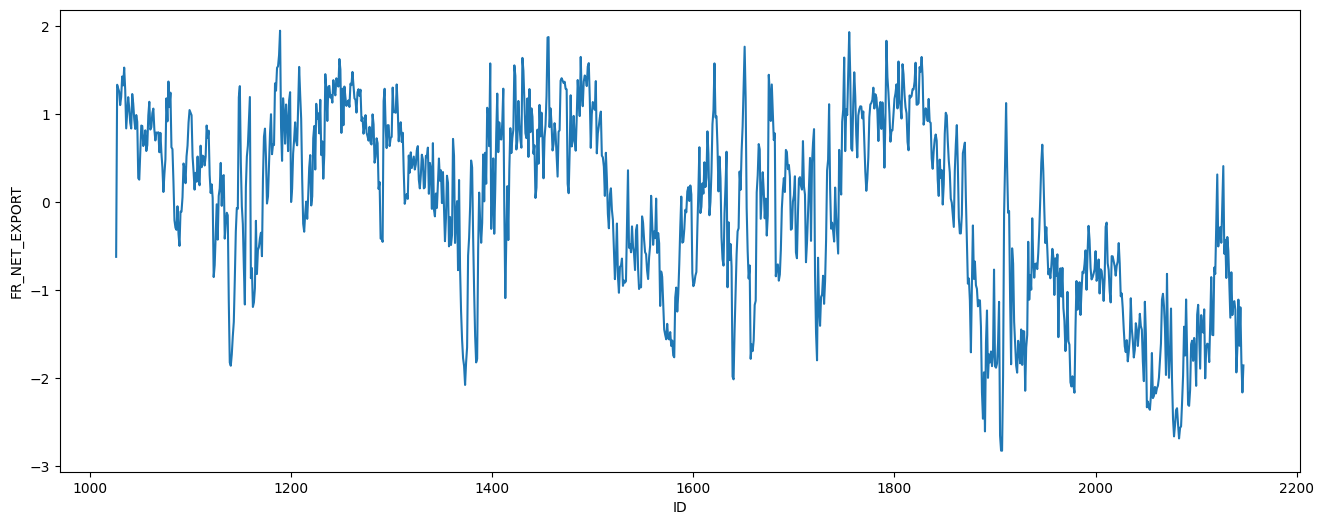

<Figure size 640x480 with 0 Axes>

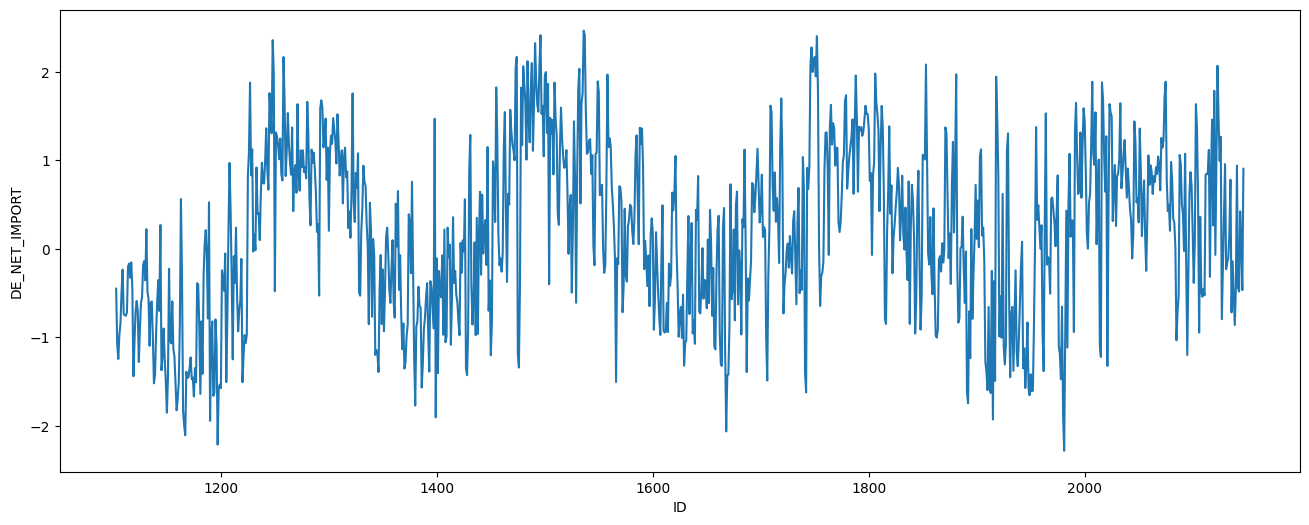

<Figure size 640x480 with 0 Axes>

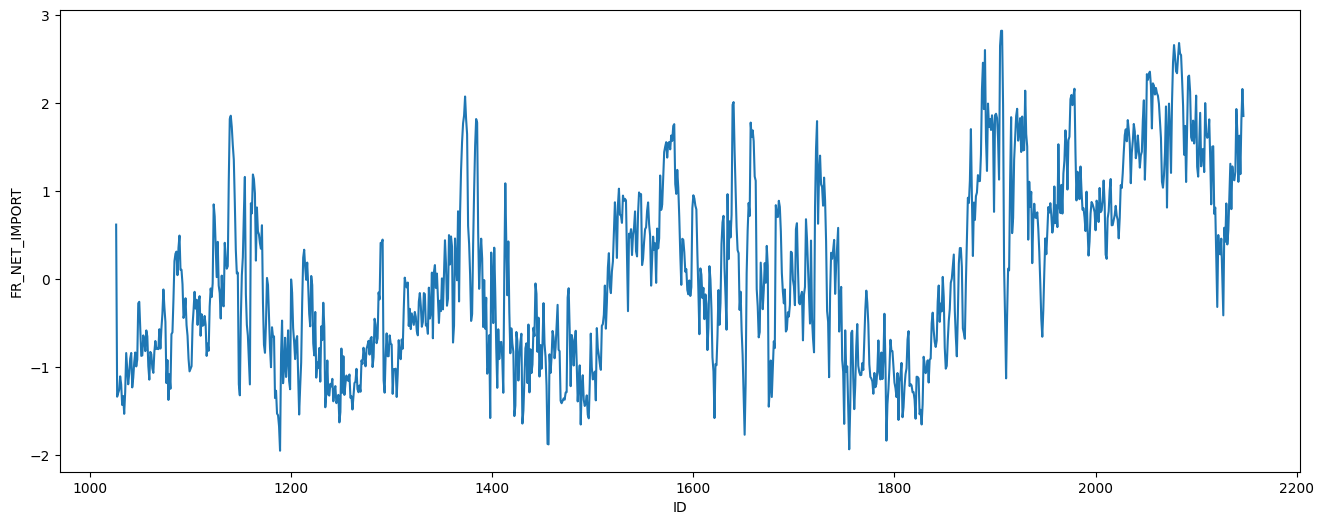

<Figure size 640x480 with 0 Axes>

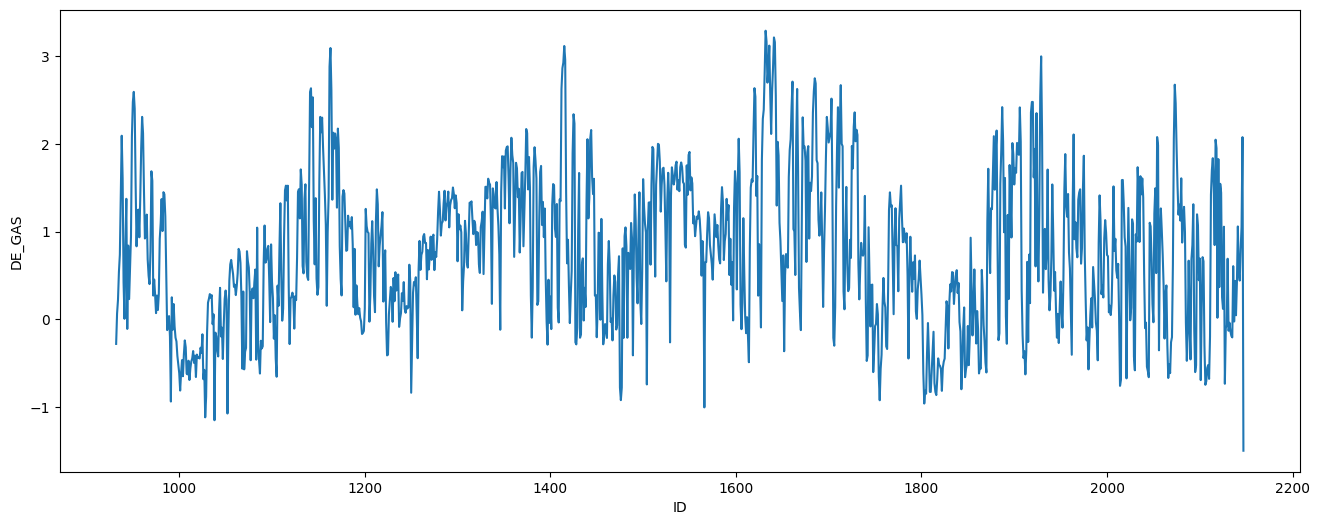

<Figure size 640x480 with 0 Axes>

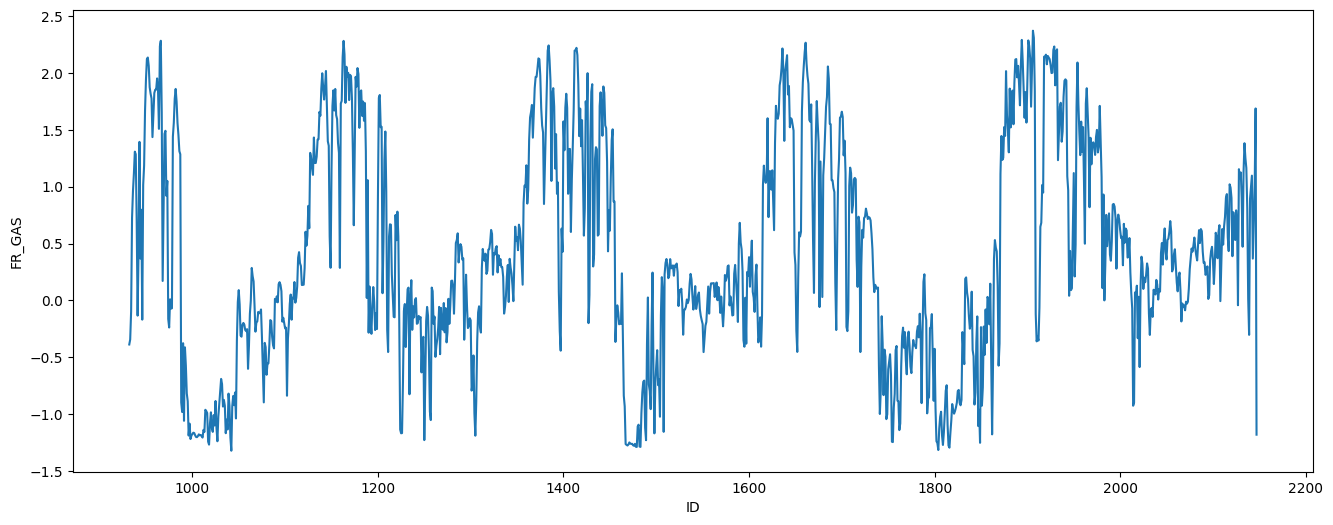

<Figure size 640x480 with 0 Axes>

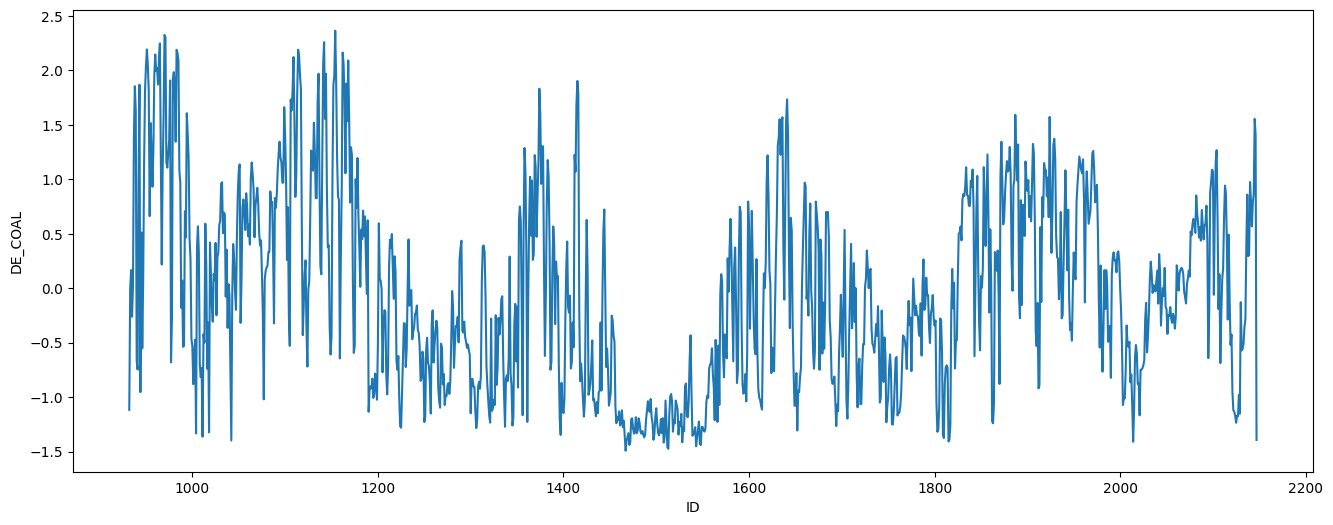

<Figure size 640x480 with 0 Axes>

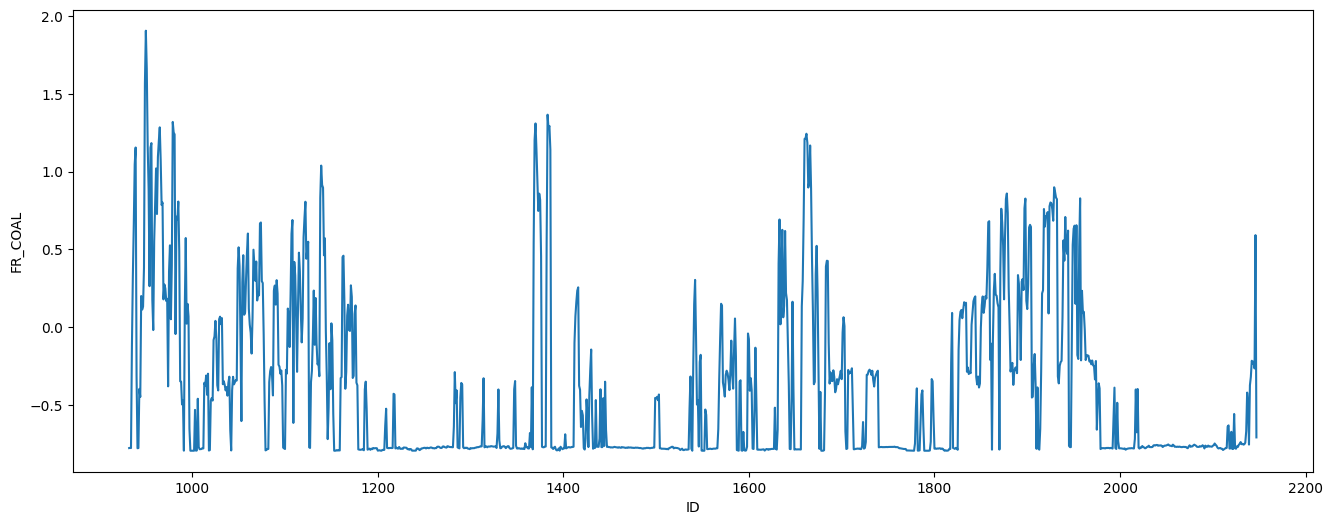

<Figure size 640x480 with 0 Axes>

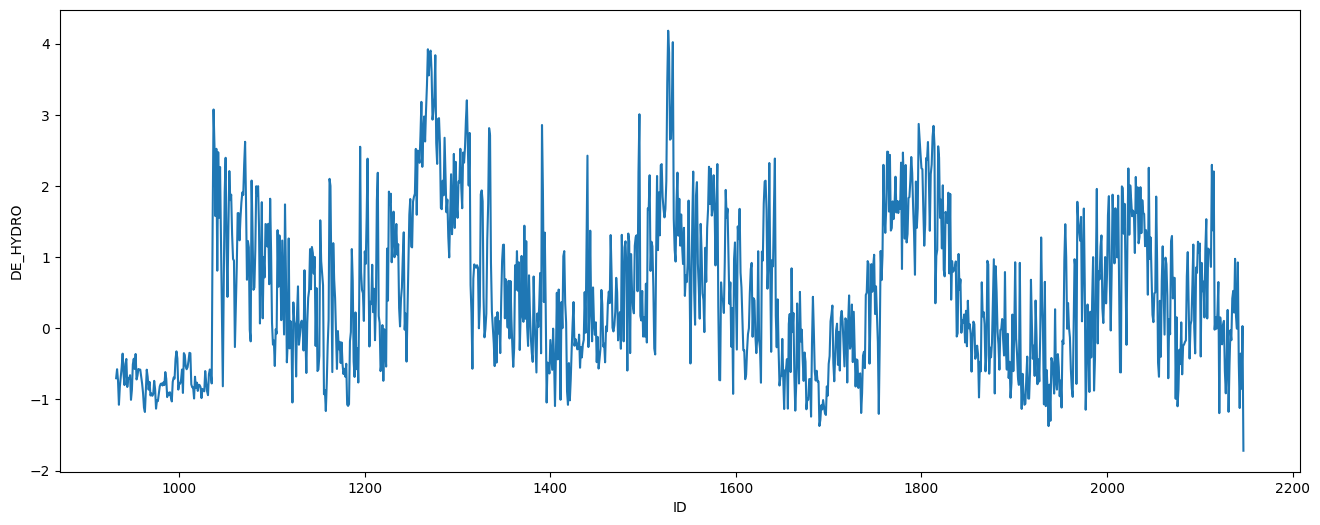

<Figure size 640x480 with 0 Axes>

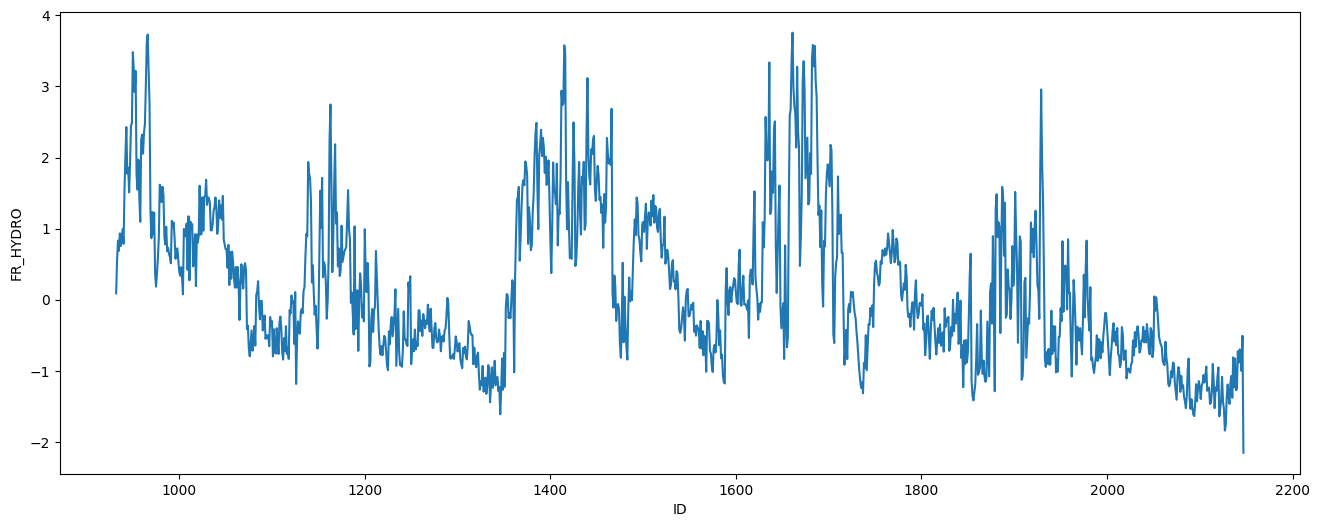

<Figure size 640x480 with 0 Axes>

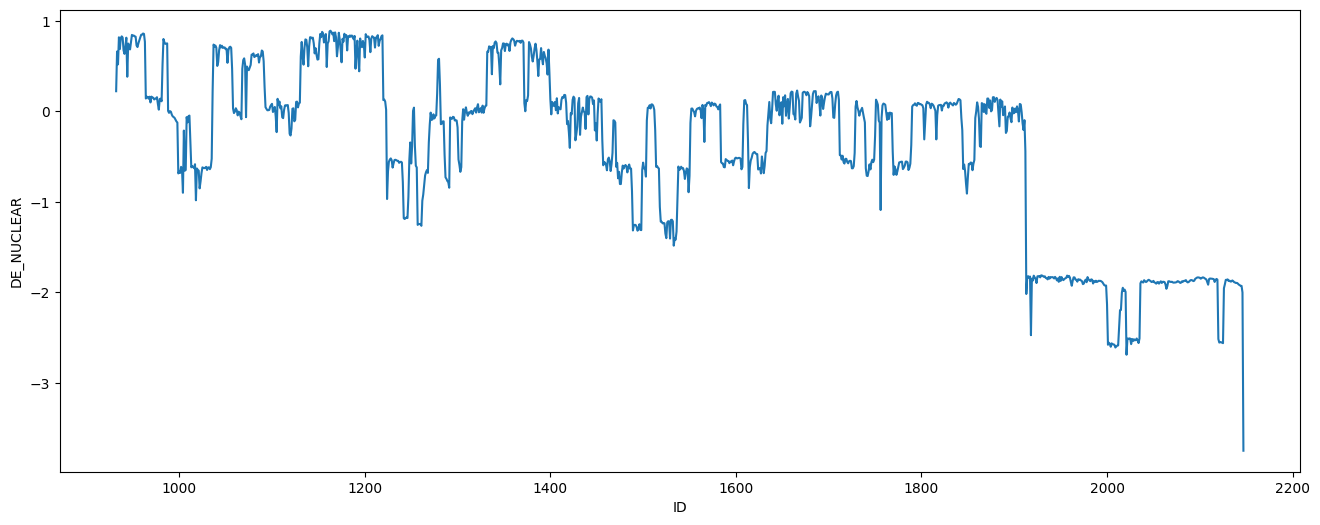

<Figure size 640x480 with 0 Axes>

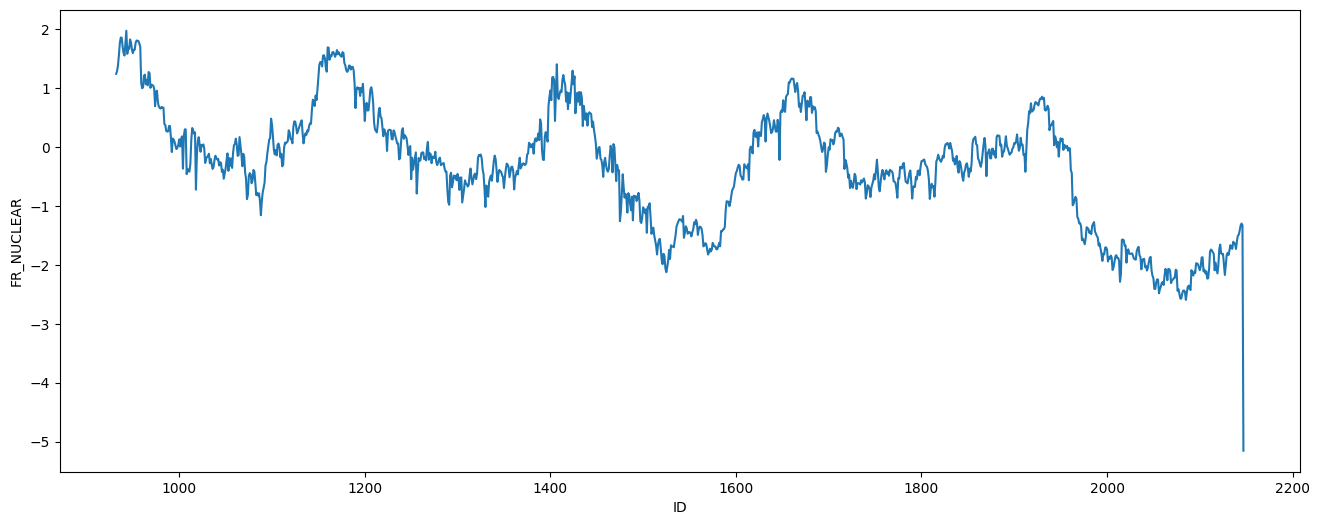

<Figure size 640x480 with 0 Axes>

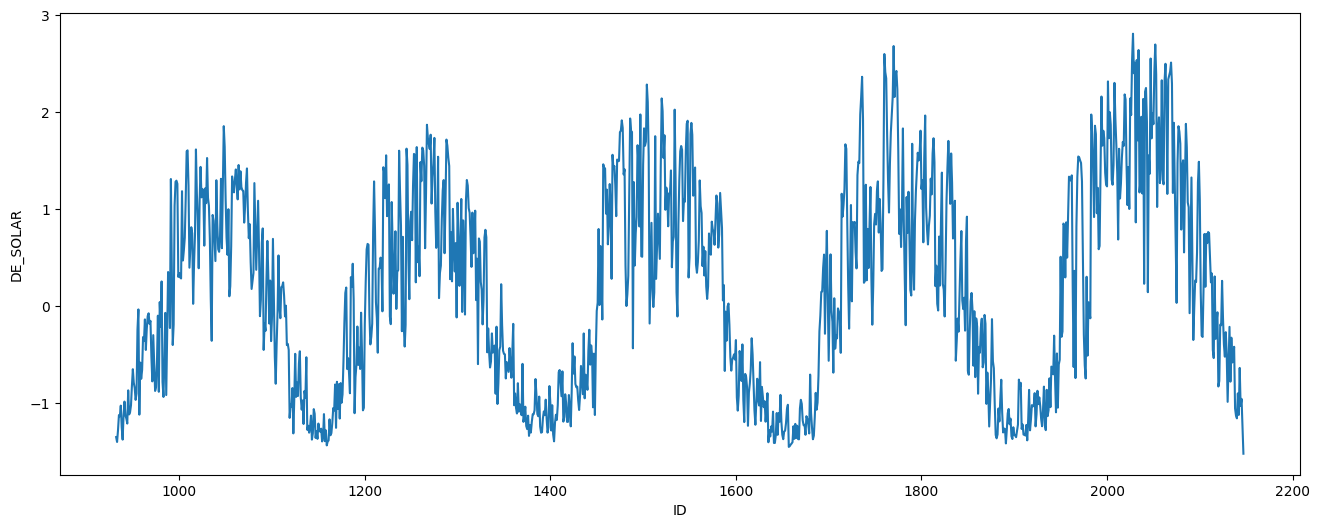

<Figure size 640x480 with 0 Axes>

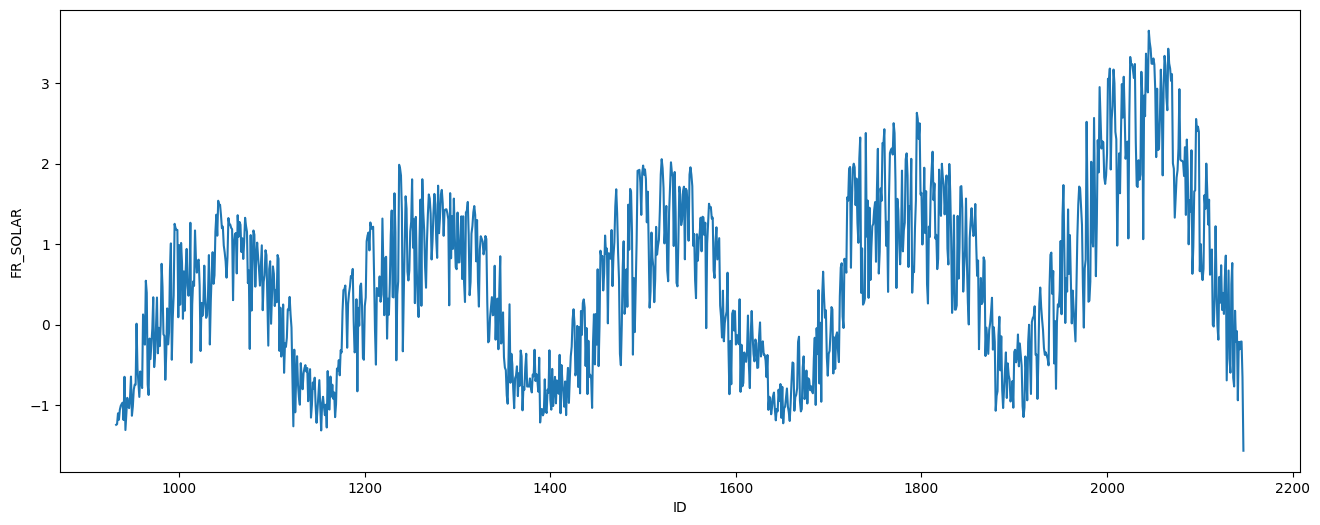

<Figure size 640x480 with 0 Axes>

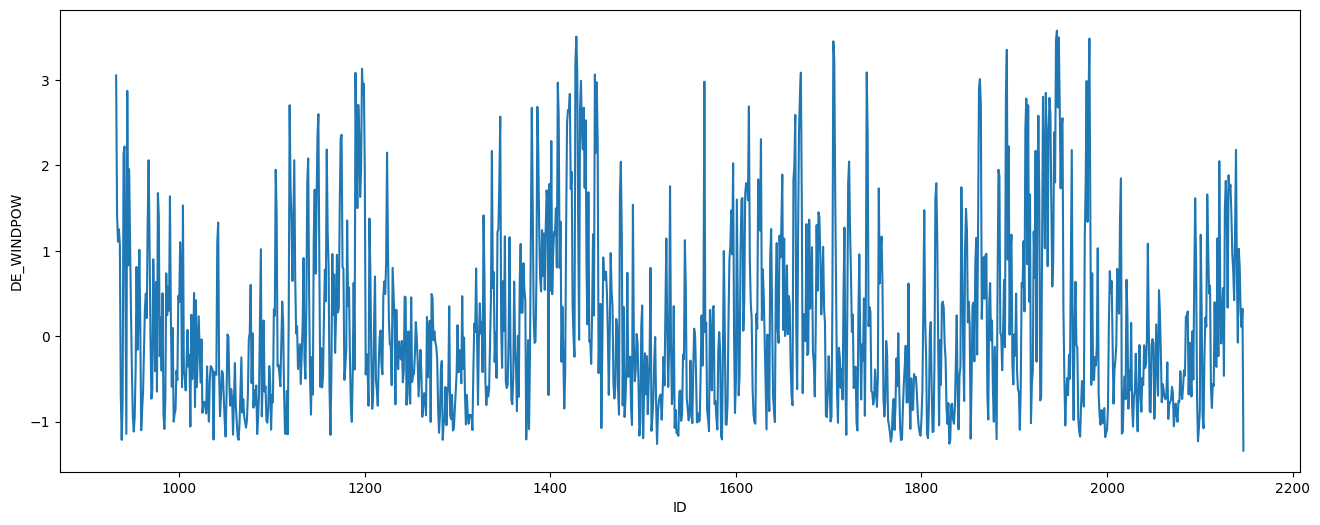

<Figure size 640x480 with 0 Axes>

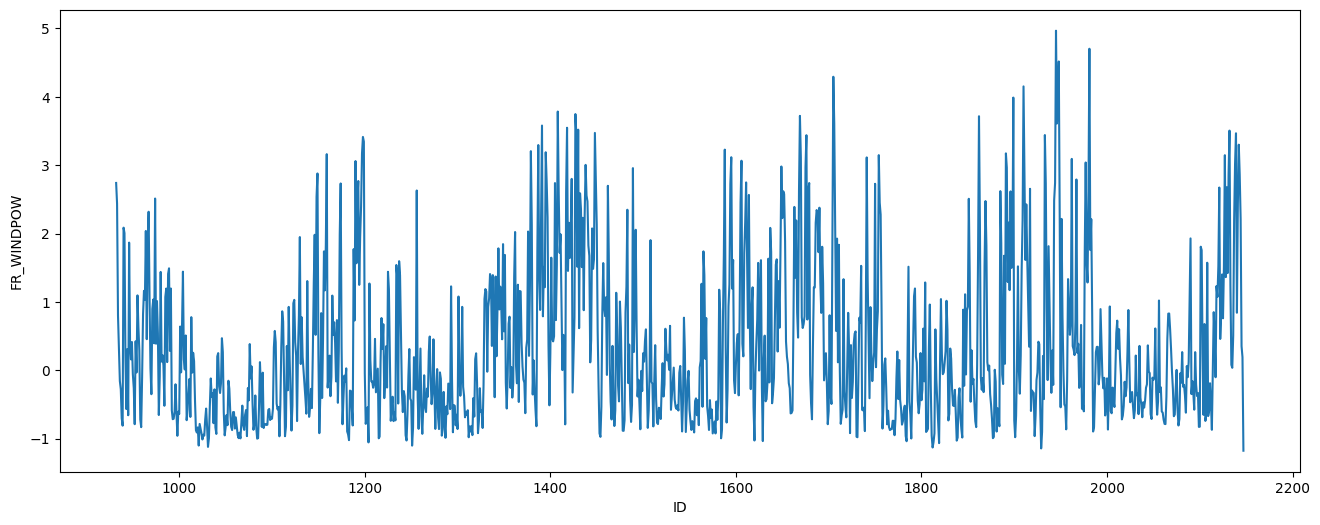

<Figure size 640x480 with 0 Axes>

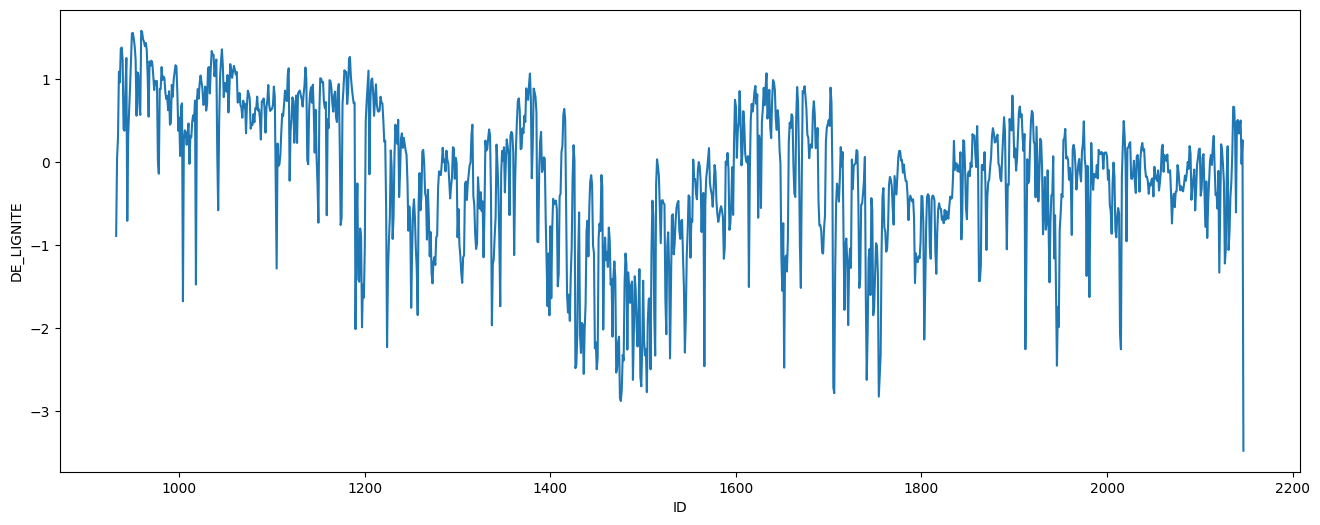

<Figure size 640x480 with 0 Axes>

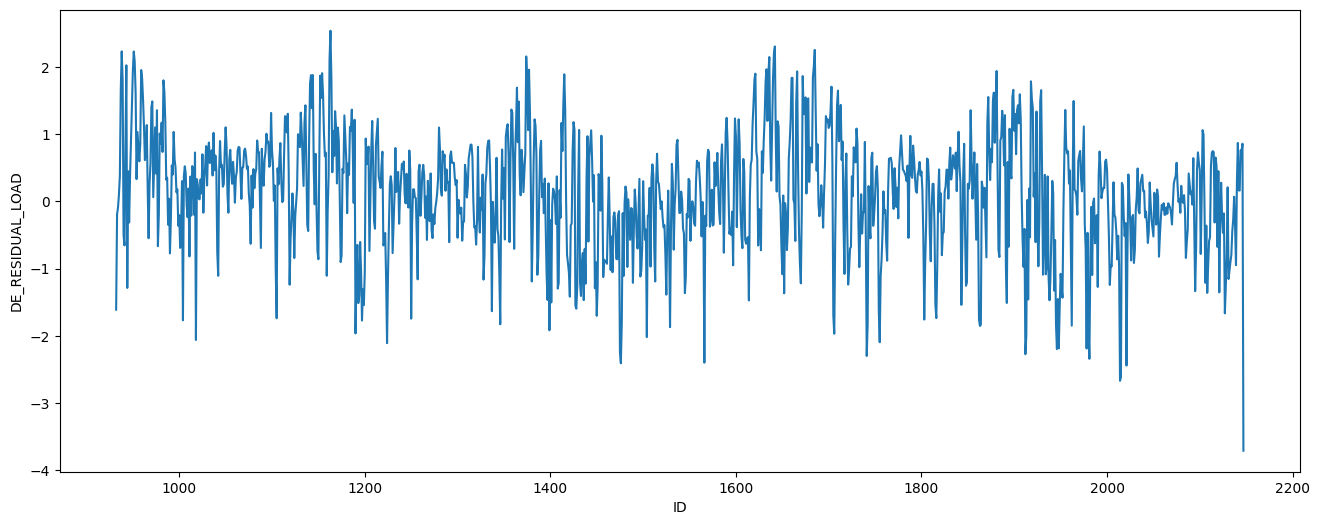

<Figure size 640x480 with 0 Axes>

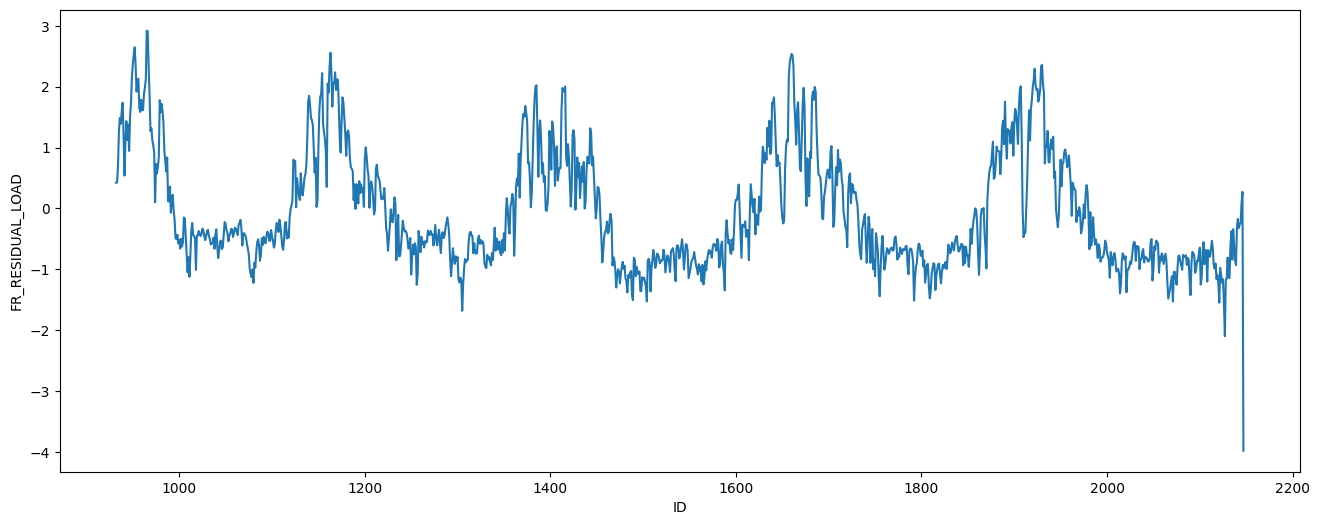

<Figure size 640x480 with 0 Axes>

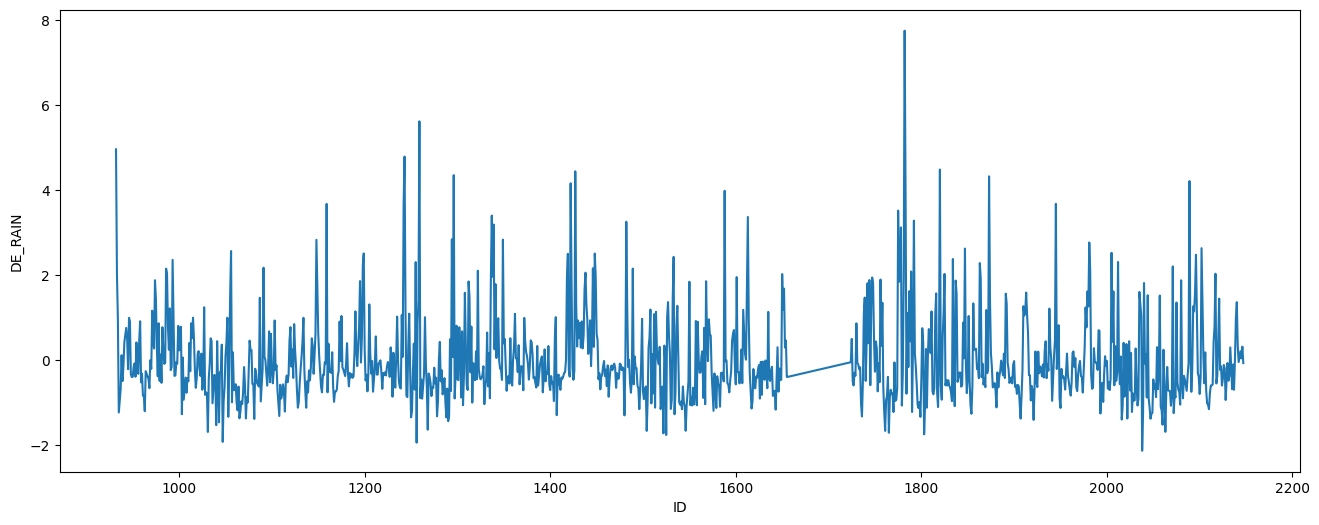

<Figure size 640x480 with 0 Axes>

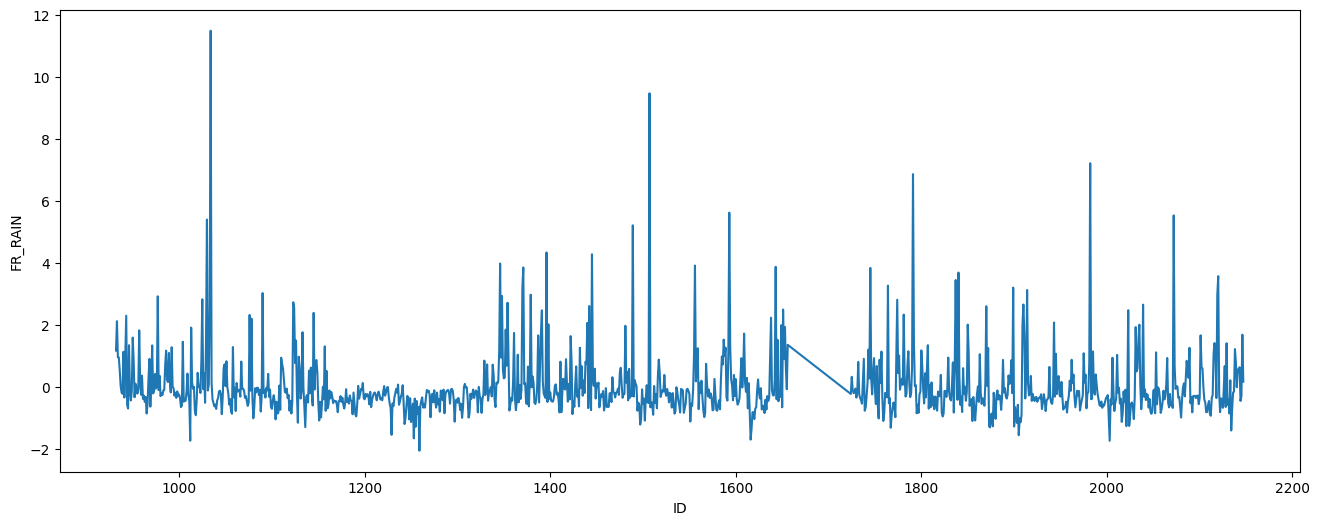

<Figure size 640x480 with 0 Axes>

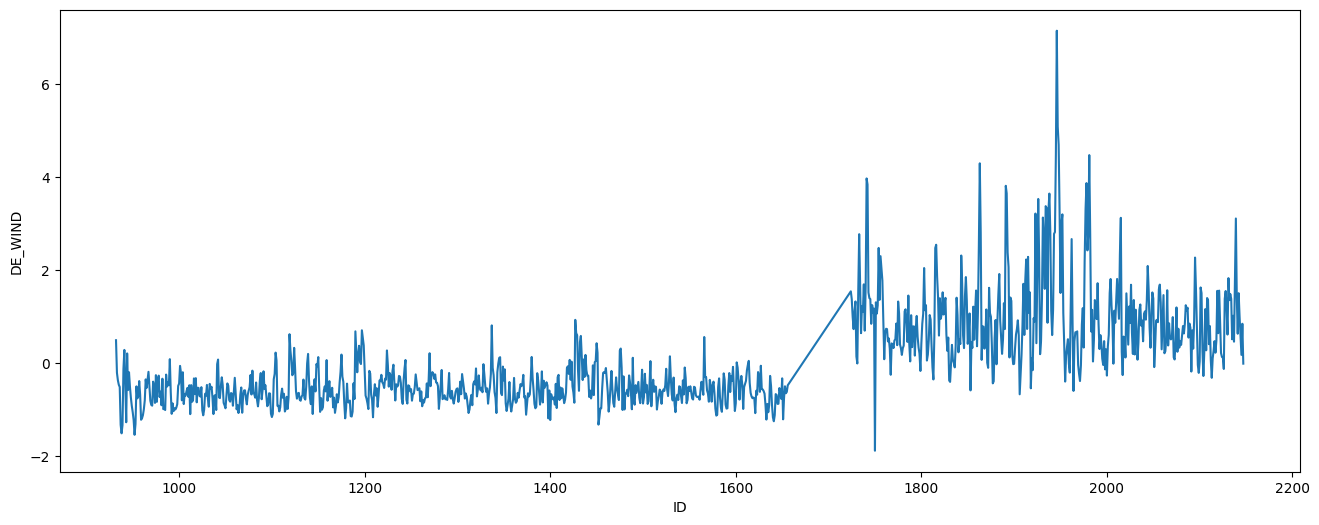

<Figure size 640x480 with 0 Axes>

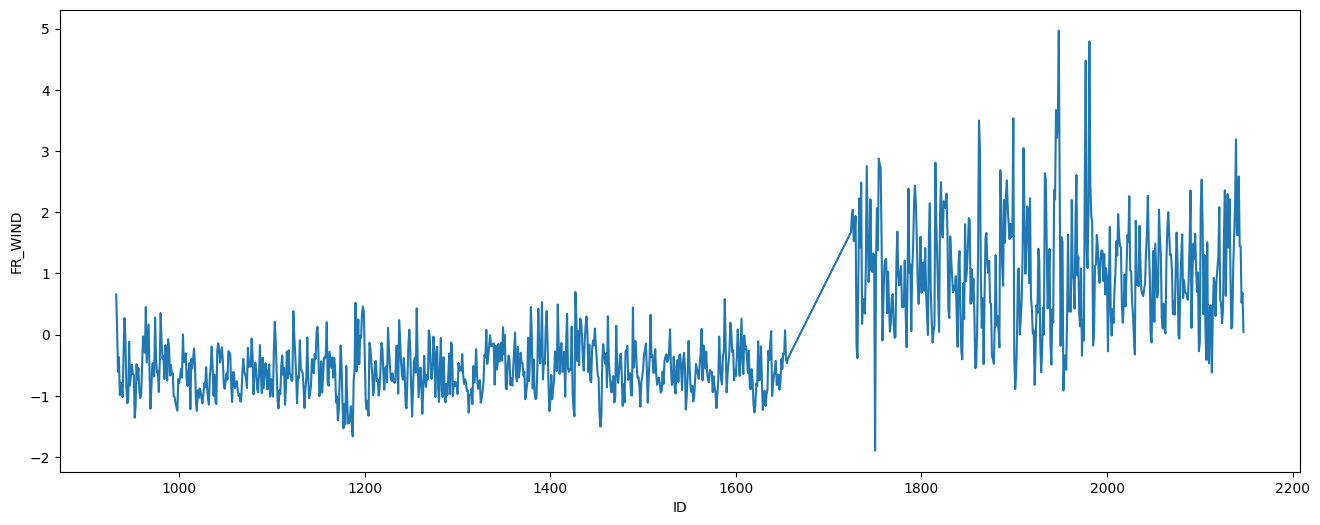

<Figure size 640x480 with 0 Axes>

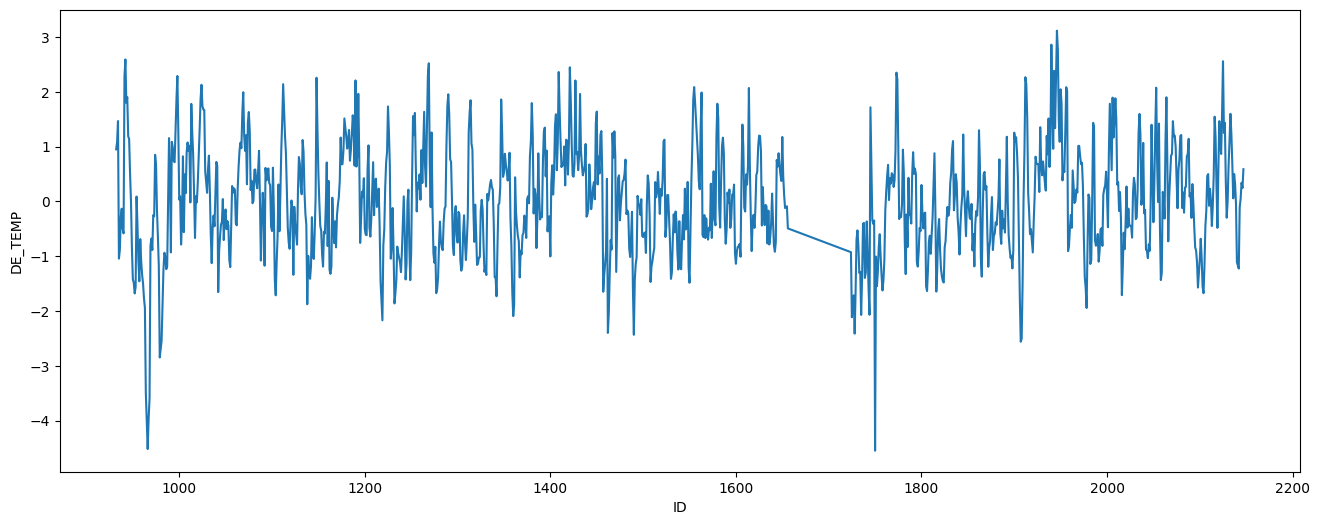

<Figure size 640x480 with 0 Axes>

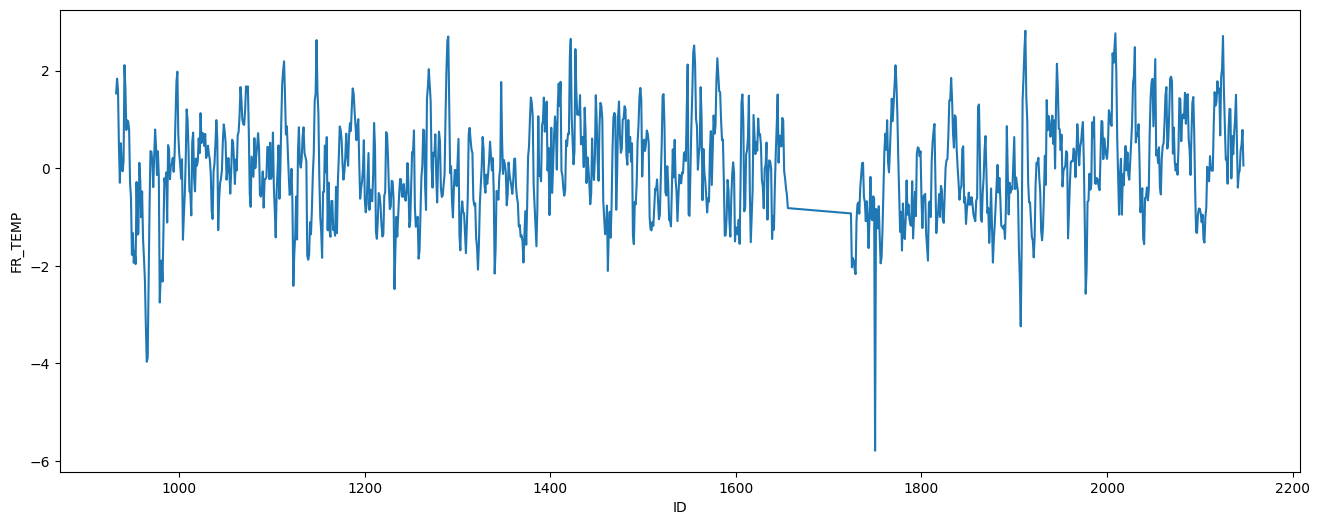

<Figure size 640x480 with 0 Axes>

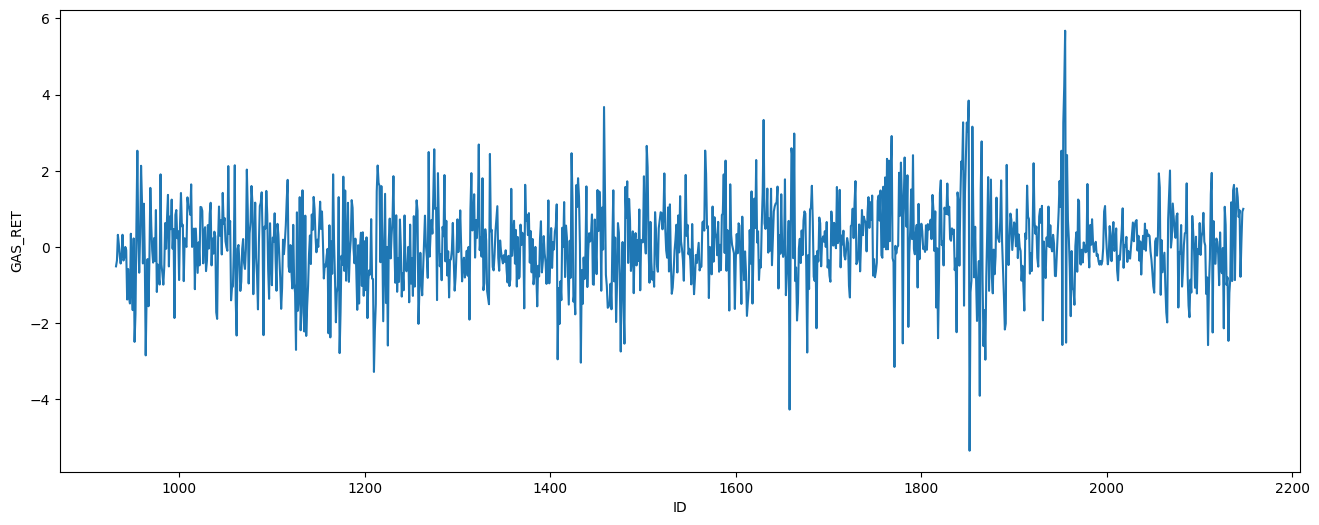

<Figure size 640x480 with 0 Axes>

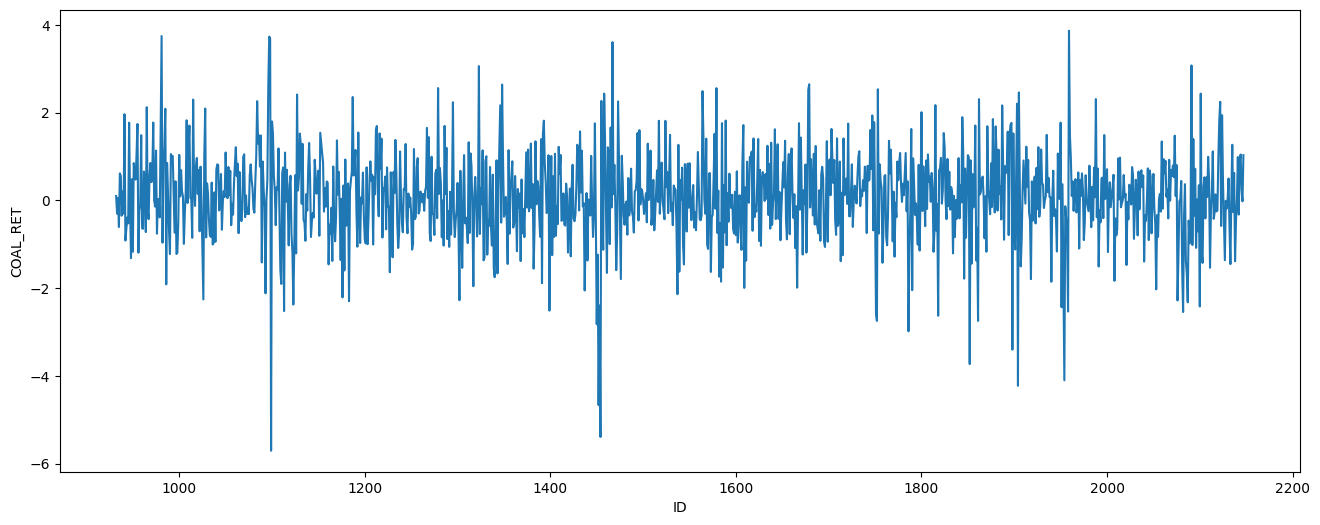

<Figure size 640x480 with 0 Axes>

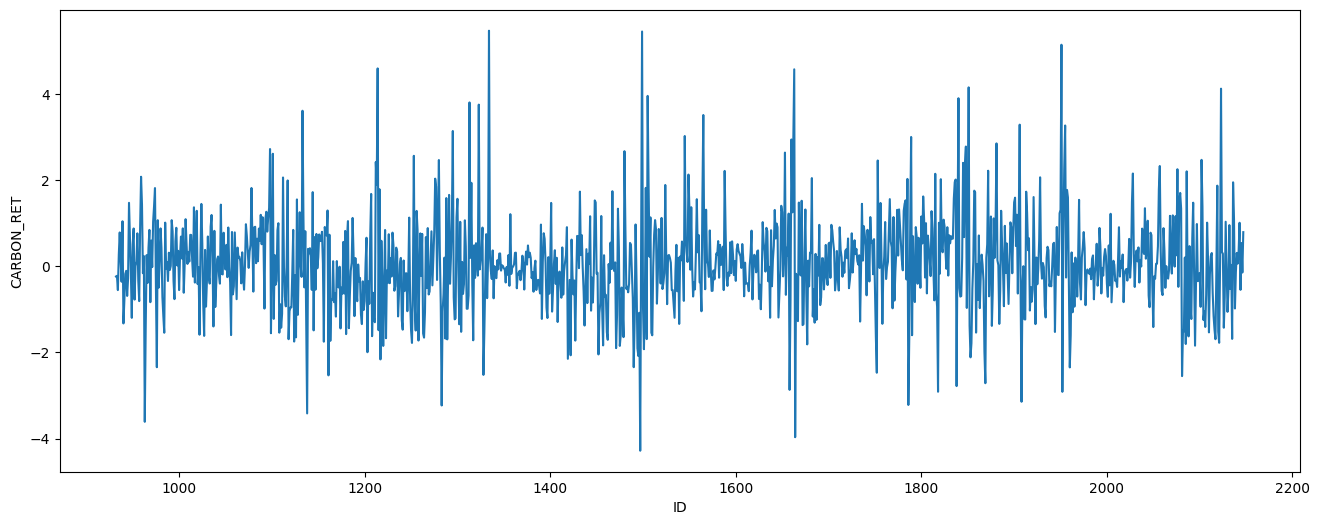

In [18]:
# Train-Test Split
from sklearn.model_selection import train_test_split
bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
# Preparing Numeric Data
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))
# Identifying Weather Variables
weather_vars = ['DE_RAIN', 'DE_WIND', 'DE_TEMP', 'FR_RAIN', 'FR_WIND', 'FR_TEMP']
# Plotting Normalized Data
for col in full_de_norm.columns:
    plt.figure()
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.lineplot(x=full_fr.index, y=full_fr[col])
    plt.show()

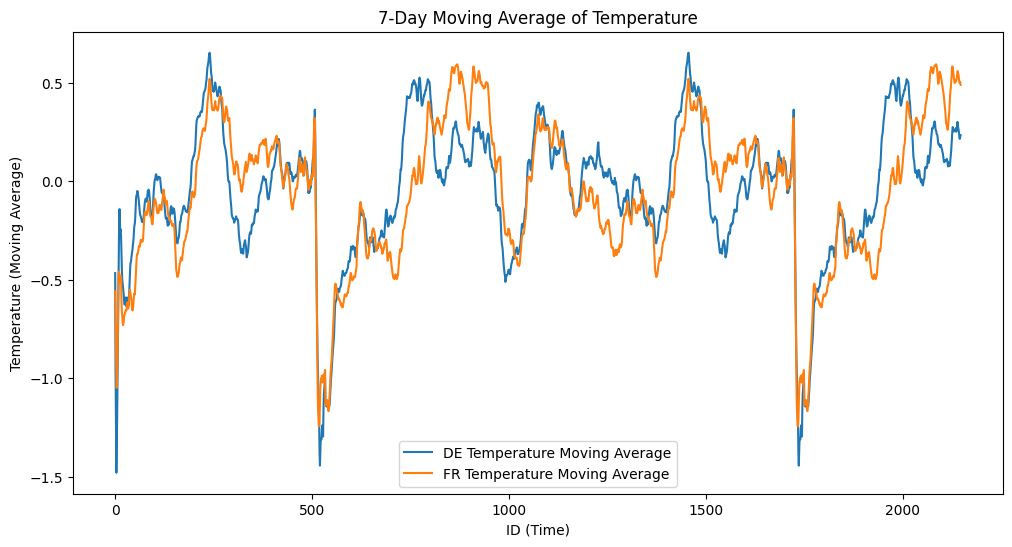

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('../challenge_data/X_train.csv').set_index('ID').sort_index()
y = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('../challenge_data/X_test.csv').set_index('ID')

# Combine training and test datasets
full = pd.concat([df, true_test]).sort_index()

# Choose a window size for the moving average
window_size = 80  # Example: 100-day moving average

# Calculate the moving average for temperature
full['DE_TEMP_MA'] = full['DE_TEMP'].rolling(window=window_size, min_periods=1).mean()
full['FR_TEMP_MA'] = full['FR_TEMP'].rolling(window=window_size, min_periods=1).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(full.index, full['DE_TEMP_MA'], label='DE Temperature Moving Average')
plt.plot(full.index, full['FR_TEMP_MA'], label='FR Temperature Moving Average')
plt.xlabel('ID (Time)')
plt.ylabel('Temperature (Moving Average)')
plt.title('7-Day Moving Average of Temperature')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

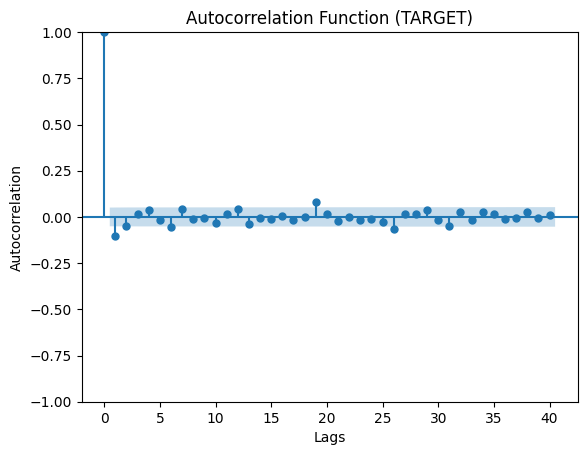

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
aut = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
plt.figure(figsize=(12, 6))
plot_acf(aut['TARGET'], lags=40)  # You can adjust the number of lags
plt.title('Autocorrelation Function (TARGET)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [21]:
from statsmodels.tsa.stattools import acf
# Compute the autocorrelation values
autocorrelation_values = acf(aut['TARGET'], nlags=40, fft=True)  # Adjust 'nlags' as needed

# Print the autocorrelation values
for lag, value in enumerate(autocorrelation_values):
    print(f"Lag {lag}: {value}")

Lag 0: 1.0
Lag 1: -0.10479088680251424
Lag 2: -0.04710897306283744
Lag 3: 0.014607925710471157
Lag 4: 0.03722648827838236
Lag 5: -0.01746951678786256
Lag 6: -0.053384409116567944
Lag 7: 0.04134281627332301
Lag 8: -0.01355487544854191
Lag 9: -0.0057295405765432125
Lag 10: -0.031779348898386545
Lag 11: 0.017249342079368537
Lag 12: 0.04171196557333309
Lag 13: -0.03902087888235032
Lag 14: -0.008382792274977652
Lag 15: -0.013674949732517793
Lag 16: 0.005927237712620111
Lag 17: -0.0171077296805538
Lag 18: -0.002657222500438734
Lag 19: 0.0784510629653751
Lag 20: 0.013546380749657045
Lag 21: -0.022264227630007377
Lag 22: -0.0012331452290123134
Lag 23: -0.015035959556526406
Lag 24: -0.009366655190373167
Lag 25: -0.02713848493438543
Lag 26: -0.06476823502277543
Lag 27: 0.013819848719155755
Lag 28: 0.016000506534390307
Lag 29: 0.03580141230622033
Lag 30: -0.015162664674125012
Lag 31: -0.049678145956756264
Lag 32: 0.028987440532554268
Lag 33: -0.017034661975646827
Lag 34: 0.02716089272152868
Lag 3

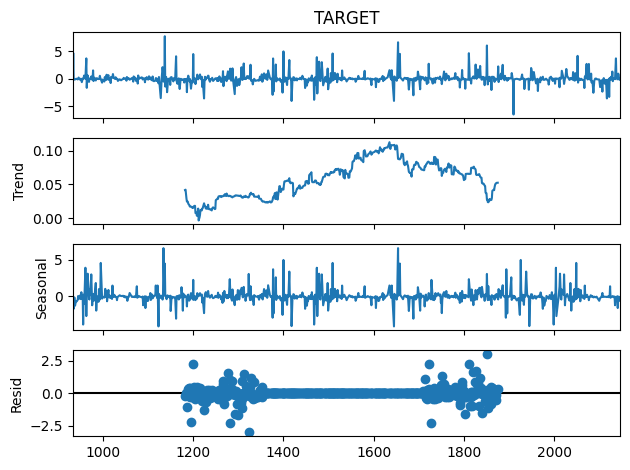

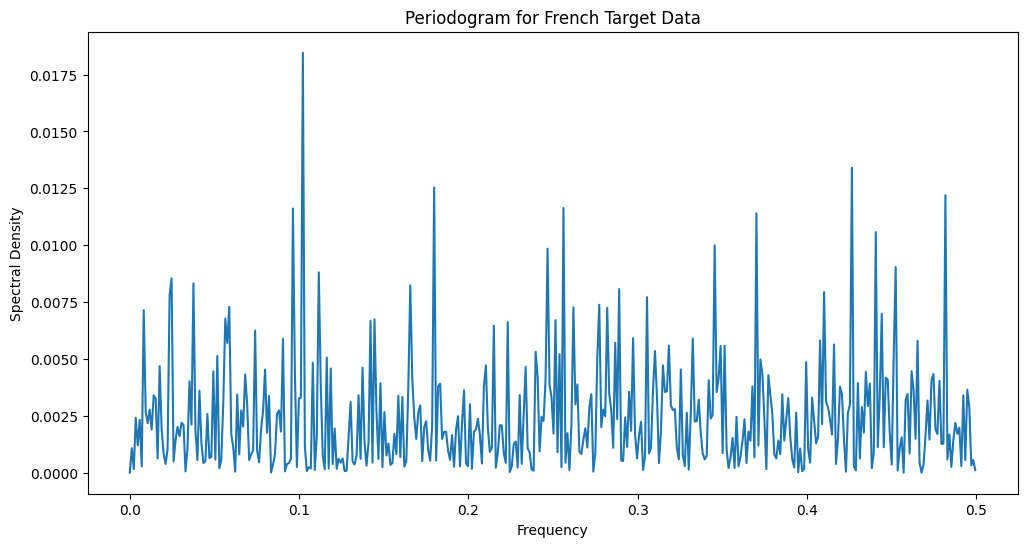

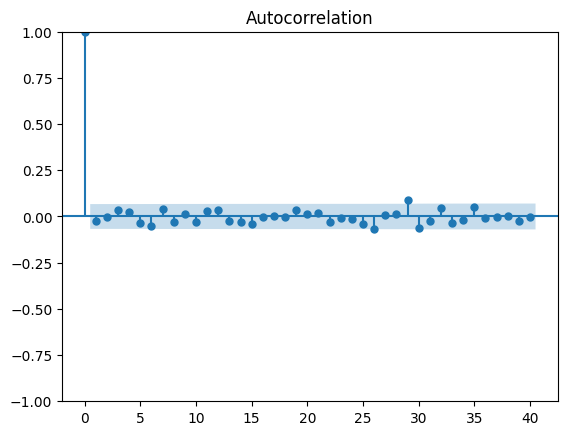

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y_fr['TARGET'], model='additive', period=365)

# Plot the decomposition results
decomposition.plot()
plt.show()
from scipy.signal import periodogram

frequencies, spectrum = periodogram(y_fr['TARGET'], scaling='spectrum')

plt.figure(figsize=(12, 6))
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Periodogram for French Target Data')
plt.show()
from statsmodels.graphics.tsaplots import plot_acf

# Adjust 'lags' based on your data and the suspected seasonal period
plot_acf(y_fr['TARGET'], lags=40)
plt.show()

In [23]:
import pandas as pd

# Load the datasets
df_train = pd.read_csv('../challenge_data/X_train.csv').set_index('ID').sort_index()
y_train = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
df_test = pd.read_csv('../challenge_data/X_test.csv').set_index('ID').sort_index()


de_train = df_train[df_train['COUNTRY'] == 'DE']
fr_train = df_train[df_train['COUNTRY'] == 'FR']

y_de_train = y_train[y_train.index.isin(de_train.index)]
y_fr_train = y_train[y_train.index.isin(fr_train.index)]

In [24]:
print(df_train.shape)
print(df_test.shape)

(1494, 34)
(654, 34)


In [25]:
print(de_train.shape)
print(df_test[df_test['COUNTRY'] == 'DE'].shape)

(643, 34)
(289, 34)


In [26]:
print(fr_train.shape)
print(df_test[df_test['COUNTRY'] == 'FR'].shape)

(851, 34)
(365, 34)


In [27]:
de_full = pd.concat([de_train, df_test[df_test['COUNTRY'] == 'DE']]).sort_index()
fr_full = pd.concat([fr_train, df_test[df_test['COUNTRY'] == 'FR']]).sort_index()

In [28]:
de_full.drop('COUNTRY', axis=1, inplace=True)
fr_full.drop('COUNTRY', axis=1, inplace=True)

de_full = de_full.join(de_full.shift(1), rsuffix='_prev_day')
fr_full = fr_full.join(fr_full.shift(1), rsuffix='_prev_day')

print(de_full.shape)

(932, 66)


In [29]:
fr_full.head().T

ID                           932         933         934        935        936
DAY_ID               1151.000000  992.000000  740.000000  52.000000  28.000000
DE_CONSUMPTION          0.931983    0.880508    0.683673   1.231695   1.408520
FR_CONSUMPTION          0.946786    0.881603    0.813651   1.269656   1.391108
DE_FR_EXCHANGE               NaN         NaN         NaN        NaN        NaN
FR_DE_EXCHANGE               NaN         NaN         NaN        NaN        NaN
...                          ...         ...         ...        ...        ...
DE_TEMP_prev_day             NaN    0.949327    1.075974   1.465248  -1.044338
FR_TEMP_prev_day             NaN    1.533169    1.835761   1.605309   0.456897
GAS_RET_prev_day             NaN   -0.509720   -0.355296   0.317321   0.078996
COAL_RET_prev_day            NaN    0.100740   -0.301449   0.050629  -0.606772
CARBON_RET_prev_day          NaN   -0.235452   -0.220830  -0.551201   0.270359

[66 rows x 5 columns]

In [30]:
window_size = 50  # Example window size, can be adjusted

# Calculate moving averages for each column
for column in de_full.columns:
    if de_full[column].isnull().any():
        de_full[column+'_MA'] = de_full[column].rolling(window=window_size, min_periods=1).mean()
for column in de_full.columns:
    if '_MA' in column:
        original_column = column.replace('_MA', '')
        de_full[original_column].fillna(de_full[column], inplace=True)
        

for column in fr_full.columns:
    if fr_full[column].isnull().any():
        fr_full[column+'_MA'] = fr_full[column].rolling(window=window_size, min_periods=1).mean()
for column in fr_full.columns:
    if '_MA' in column:
        original_column = column.replace('_MA', '')
        fr_full[original_column].fillna(fr_full[column], inplace=True)

# Remove the moving average columns after filling missing values
de_full.drop([col for col in de_full.columns if '_MA' in col], axis=1, inplace=True)
fr_full.drop([col for col in fr_full.columns if '_MA' in col], axis=1, inplace=True)

In [31]:
fr_full

DAY_ID  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  FR_DE_EXCHANGE  \
ID                                                                             
932     1151        0.931983        0.946786             NaN             NaN   
933      992        0.880508        0.881603             NaN             NaN   
934      740        0.683673        0.813651             NaN             NaN   
935       52        1.231695        1.269656             NaN             NaN   
936       28        1.408520        1.391108             NaN             NaN   
...      ...             ...             ...             ...             ...   
2143     112        0.979093        0.338229        1.138619       -1.138619   
2144     102        1.009837        0.237311       -0.093751        0.093751   
2145     414        0.762955        0.151155        1.215111       -1.215111   
2146     589        1.093597        0.269156        2.294389       -2.294389   
2147     190       -7.433311       -4.591011        0.870430       -0.870430   

      DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  FR_NET_IMPORT    DE_GAS  \
ID                                                                           
932             NaN            NaN            NaN            NaN -0.279936   
933             NaN            NaN            NaN            NaN  0.066808   
934             NaN            NaN            NaN            NaN  0.223300   
935             NaN            NaN            NaN            NaN  0.541972   
936             NaN            NaN            NaN            NaN  0.736501   
...             ...            ...            ...            ...       ...   
2143       0.480707      -1.631364      -0.480707       1.631364  0.442421   
2144      -0.425785      -1.194162       0.425785       1.194162  0.796232   
2145      -0.055368      -1.817169       0.055368       1.817169  1.054524   
2146       0.465162      -2.162553      -0.465162       2.162553  2.078297   
2147      -0.906050      -1.855136       0.906050       1.855136 -1.498254   

        FR_GAS   DE_COAL   FR_COAL  DE_HYDRO  FR_HYDRO  DE_NUCLEAR  \
ID                                                                   
932  -0.388614 -1.116400 -0.777920 -0.702349  0.090513    0.224166   
933  -0.344762 -0.006085 -0.776396 -0.576288  0.554155    0.663309   
934  -0.097421  0.166830 -0.778026 -0.731163  0.831906    0.520983   
935   0.726137 -0.262330 -0.121198 -1.075728  0.690618    0.820342   
936   0.963235  0.019075  0.327328 -0.820520  0.932772    0.689873   
...        ...       ...       ...       ...       ...         ...   
2143  0.367265  0.785531 -0.234862 -1.121350 -0.696835   -1.919768   
2144  0.675199  0.865687 -0.222342 -0.355897 -0.714343   -1.928200   
2145  1.009240  1.554055 -0.265893 -0.850534 -1.001921   -1.928367   
2146  1.688479  1.411068  0.591205  0.030002 -0.507002   -2.001415   
2147 -1.182301 -1.392929 -0.709300 -1.721637 -2.151098   -3.750836   

      FR_NUCLEAR  DE_SOLAR  FR_SOLAR  DE_WINDPOW  FR_WINDPOW  DE_LIGNITE  \
ID                                                                         
932     1.238111 -1.348875 -1.242489    3.053773    2.739401   -0.887516   
933     1.283956 -1.399163 -1.235034    1.413867    2.436178    0.050227   
934     1.386685 -1.279730 -1.100344    1.107618    0.801223    0.296333   
935     1.557844 -1.122654 -1.179317    1.251842    0.322378    1.091601   
936     1.760980 -1.134702 -1.054363    1.072079   -0.158598    0.963711   
...          ...       ...       ...         ...         ...         ...   
2143   -1.418159 -0.636313 -0.304667    0.811159    2.862619    0.436883   
2144   -1.331032 -1.029400 -0.211453    0.292369    2.213918    0.503896   
2145   -1.301150 -0.955153 -0.208504    0.105193    0.351713   -0.018965   
2146   -1.330165 -1.239191 -0.653159    0.321488    0.190965    0.266504   
2147   -5.153722 -1.520505 -1.564248   -1.341794   -1.176882   -3.478301   

      DE_RESIDUAL_LOAD  FR_RESIDUAL_LOAD   DE_RAIN

In [32]:
de_test_final = de_full[de_full['DAY_ID'].isin(df_test[df_test['COUNTRY'] == 'DE']['DAY_ID'])]
fr_test_final = fr_full[fr_full['DAY_ID'].isin(df_test[df_test['COUNTRY'] == 'FR']['DAY_ID'])]
de_train_final = de_full[de_full['DAY_ID'].isin(df_train[df_train['COUNTRY'] == 'DE']['DAY_ID'])]
fr_train_final = fr_full[fr_full['DAY_ID'].isin(df_train[df_train['COUNTRY'] == 'FR']['DAY_ID'])]
print(de_test_final.shape)
print(de_train_final.shape)

(289, 66)
(643, 66)


In [35]:
de_train_final.columns

Index(['DAY_ID', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'DAY_ID_prev_day', 'DE_CONSUMPTION_prev_day', 'FR_CONSUMPTION_prev_day',
       'DE_FR_EXCHANGE_prev_day', 'FR_DE_EXCHANGE_prev_day',
       'DE_NET_EXPORT_prev_day', 'FR_NET_EXPORT_prev_day',
       'DE_NET_IMPORT_prev_day', 'FR_NET_IMPORT_prev_day', 'DE_GAS_prev_day',
       'FR_GAS_prev_day', 'DE_COAL_prev_day', 'FR_COAL_prev_day',
       'DE_HYDRO_prev_day', 'FR_HYDRO_prev_day', 'DE_NUCLEAR_prev_day',
       'FR_NUCLEAR_prev_day', 'DE_SOLAR_prev_day', 'FR_SOLAR_prev_day',
       'DE

In [36]:
columns_to_remove = [
    "DAY_ID", "FR_CONSUMPTION", "FR_DE_EXCHANGE", "FR_NET_EXPORT",
    "DE_NET_IMPORT", "FR_NET_IMPORT", "FR_GAS", "FR_COAL", "FR_HYDRO", 
    "FR_NUCLEAR", "FR_SOLAR", "FR_WINDPOW", "FR_RESIDUAL_LOAD", 
    "FR_RAIN", "FR_WIND", "FR_TEMP"
]
# Add columns with '_prev_day' suffix
columns_to_remove += [col + '_prev_day' for col in columns_to_remove]
# Remove the columns from de_train_final
de_train_final = de_train_final.drop(columns=columns_to_remove, errors='ignore')
de_train_final

DE_CONSUMPTION  DE_FR_EXCHANGE  DE_NET_EXPORT    DE_GAS   DE_COAL  \
ID                                                                       
0          0.583923        0.778353       0.931374  0.836731  0.200623   
2          0.548187       -0.179177       0.588670  1.062806  0.292958   
3          0.470907       -0.707035       0.111881  1.223117  0.150620   
4          0.284447        0.389806       1.506291  0.202693 -0.665840   
5          0.551274        0.226737       1.205343  0.637224 -0.746381   
..              ...             ...            ...       ...       ...   
926        1.032122        0.451691       0.437667  0.533996  0.568480   
927        0.979093        1.138619       0.480707  0.442421  0.785531   
928        1.009837       -0.093751      -0.425785  0.796232  0.865687   
929        0.762955        1.215111      -0.055368  1.054524  1.554055   
930        1.093597        2.294389       0.465162  2.078297  1.411068   

     DE_HYDRO  DE_NUCLEAR  DE_SOLAR  DE_WINDPOW  DE_LIGNITE  DE_RESIDUAL_LOAD  \
ID                                                                              
0    0.076310    0.780177  0.390828   -0.012385    0.625910          0.293219   
2   -0.487960    0.832773  0.447086   -0.329384    0.722983          0.529501   
3    0.044238    0.842046 -0.053067   -0.446433    0.707787          0.738900   
4   -0.738709    0.126256  1.431625    0.465544    0.500184         -0.656051   
5   -0.014076    0.131863  1.377499    0.639742    0.247893         -0.613143   
..        ...         ...       ...         ...         ...               ...   
926 -0.473725   -1.914119 -1.120453    1.023247    0.347272          0.163624   
927 -1.121350   -1.919768 -0.636313    0.811159    0.436883          0.160769   
928 -0.355897   -1.928200 -1.029400    0.292369    0.503896          0.760865   
929 -0.850534   -1.928367 -0.955153    0.105193   -0.018965          0.736311   
930  0.030002   -2.001415 -1.239191    0.321488    0.266504          0.857835   

      DE_RAIN   DE_WIND   DE_TEMP   GAS_RET  COAL_RET  CARBON_RET  \
ID                                                                  
0   -0.047033 -0.370706 -0.466573  1.602466  1.527066    1.790950   
2   -0.274901 -0.248671 -1.817422  1.596267  1.409234    0.593396   
3   -0.672022 -0.409482 -2.170678  0.172622 -0.847545   -0.313360   
4   -0.300883 -0.444411 -0.795390 -1.951199  0.273857   -1.847703   
5   -0.347601 -0.530196 -0.511760 -0.307876  0.225957   -0.408372   
..        ...       ...       ...       ...       ...         ...   
926 -0.042241  1.506315 -1.225979  0.785530 -0.322581    0.362803   
927  0.086420  1.007158 -0.107380  0.961630  0.891689    1.012246   
928  0.213069  0.601170  0.047149 -0.784590  1.046452   -0.545607   
929  0.045473  0.179553  0.340100  0.149340  0.251444    0.541685   
930  0.321287  0.849288  0.242526  0.926260 -0.021154   -0.144349   

     DE_CONSUMPTION_prev_day  DE_FR_EXCHANGE_prev_day  DE_NET_EXPORT_prev_day  \
ID                                                                              
0                        NaN                      NaN                     NaN   
2                   0.599993                 0.141289                0.694028   
3                   0.548187                -0.179177                0.588670   
4                   0.470907                -0.707035                0.111881   
5                   0.284447                 0.389806                1.506291   
..                       ...                      ...                     ...   
926                 0.751637                 0.198740               -0.941415   
927                 1.032122                 0.451691                0.437667   
928                 0.979093                 1.138619                0.480707   
929                 1.009837                -0.093751               -0.425785   
930                 0.762955                 1.215111               -0.055368   

     DE_GAS_prev_day  DE_COAL_prev_d

In [37]:

print(de_train_final.shape)

(643, 34)


In [38]:
de_test_final = de_test_final.drop(columns=columns_to_remove, errors='ignore')
de_test_final

DE_CONSUMPTION  DE_FR_EXCHANGE  DE_NET_EXPORT    DE_GAS   DE_COAL  \
ID                                                                       
1          0.599993        0.141289       0.694028  0.959734 -0.096841   
6          0.448365       -0.378787       0.972761  0.787415 -0.622520   
7          0.094138       -0.526749       1.064523 -0.028746 -1.016151   
11         0.176210       -1.192766      -1.878711  0.220693 -0.668626   
16         0.504677        0.289817       0.013198  0.206821 -0.023925   
..              ...             ...            ...       ...       ...   
904       -0.050292       -1.766032      -1.786085  1.828029 -0.425441   
911       -0.800945        0.302098       0.793661 -0.734524 -1.175361   
916        0.562798        0.334508       0.152506 -0.038867 -0.555487   
920        0.334263        1.042173       0.716838  0.606660  0.392388   
931       -7.433311        0.870430      -0.906050 -1.498254 -1.392929   

     DE_HYDRO  DE_NUCLEAR  DE_SOLAR  DE_WINDPOW  DE_LIGNITE  DE_RESIDUAL_LOAD  \
ID                                                                              
1   -0.602358    0.804110  0.500201    0.066511    0.790924          0.200128   
6   -0.295697    0.109288  1.112920    0.494851    0.260600         -0.471106   
7   -0.538727    0.019590  1.554578    0.855318   -0.539181         -1.164182   
11   1.735849   -0.531283 -0.104790   -0.097126   -0.658602          0.251752   
16   0.998352   -0.536770  0.320655    0.199129    0.088074          0.076924   
..        ...         ...       ...         ...         ...               ...   
904  0.649499   -2.515970 -0.827586   -0.234243   -0.104233          0.449441   
911 -0.601500   -1.911091 -0.520532    1.494711   -1.220382         -1.666437   
916 -0.515059   -1.870178 -0.213360    1.691505   -0.846478         -1.023857   
920  0.524983   -1.875238 -0.518482    0.765629    0.670149         -0.268089   
931 -1.721637   -3.750836 -1.520505   -1.341794   -3.478301         -3.711039   

      DE_RAIN   DE_WIND   DE_TEMP   GAS_RET  COAL_RET  CARBON_RET  \
ID                                                                  
1   -0.000759 -0.385935 -1.461775 -0.401694  0.718941   -2.161340   
6   -0.281556 -0.328795  0.250721  1.393826  0.542969    0.844307   
7   -0.357140 -0.353357  0.708057 -1.472538 -0.659916   -1.668585   
11  -0.391646 -0.210956  0.655087  0.743516 -1.637282   -0.391557   
16  -0.352986 -0.410660 -1.862329  0.081457  0.165743   -0.566256   
..        ...       ...       ...       ...       ...         ...   
904  0.483658  0.646000  0.594257 -0.211735  0.986556   -1.519865   
911 -0.192578  1.384888  1.433337  1.053799 -1.363392   -0.726740   
916 -0.377808  1.356900  1.090257 -1.204492 -0.623584    0.957544   
920 -0.098752  1.020837  0.055794  1.485898 -0.267464    1.951327   
931 -0.066275 -0.008498  0.586837  0.999103  1.031029    0.793998   

     DE_CONSUMPTION_prev_day  DE_FR_EXCHANGE_prev_day  DE_NET_EXPORT_prev_day  \
ID                                                                              
1                   0.583923                 0.778353                0.931374   
6                   0.551274                 0.226737                1.205343   
7                   0.448365                -0.378787                0.972761   
11                  0.263204                -1.224154               -1.093566   
16                  0.217317                -0.716534               -0.162479   
..                       ...                      ...                     ...   
904                 0.435731                -0.623043               -0.265518   
911                -1.087446                -1.187636               -1.267299   
916                 0.426832                -0.067732                0.229359   
920                 0.301598                -0.407957               -0.782317   
931                 1.093597                 2.294389                0.465162   

     DE_GAS_prev_day  DE_COAL_prev_d

In [39]:
de_test_final.shape

(289, 34)

In [40]:
columns_to_remove = [
    "DAY_ID", "DE_CONSUMPTION", "DE_FR_EXCHANGE", "DE_NET_EXPORT",
    "FR_NET_IMPORT", "DE_NET_IMPORT", "DE_GAS", "DE_COAL", "DE_HYDRO", 
    "DE_NUCLEAR", "DE_SOLAR", "DE_WINDPOW", "DE_RESIDUAL_LOAD", 
    "DE_RAIN", "DE_WIND", "DE_TEMP"
]
# Add columns with '_prev_day' suffix
columns_to_remove += [col + '_prev_day' for col in columns_to_remove]
# Remove the columns from de_train_final
fr_train_final = fr_train_final.drop(columns=columns_to_remove, errors='ignore')
fr_train_final

FR_CONSUMPTION  FR_DE_EXCHANGE  FR_NET_EXPORT    FR_GAS   FR_COAL  \
ID                                                                        
933         0.881603             NaN            NaN -0.344762 -0.776396   
934         0.813651             NaN            NaN -0.097421 -0.778026   
935         1.269656             NaN            NaN  0.726137 -0.121198   
936         1.391108             NaN            NaN  0.963235  0.327328   
937         1.276328             NaN            NaN  1.116439  0.658796   
...              ...             ...            ...       ...       ...   
2142        0.383270       -0.451691      -1.106814  1.097201 -0.216372   
2143        0.338229       -1.138619      -1.631364  0.367265 -0.234862   
2144        0.237311        0.093751      -1.194162  0.675199 -0.222342   
2145        0.151155       -1.215111      -1.817169  1.009240 -0.265893   
2146        0.269156       -2.294389      -2.162553  1.688479  0.591205   

      FR_HYDRO  FR_NUCLEAR  FR_SOLAR  FR_WINDPOW  DE_LIGNITE  \
ID                                                             
933   0.554155    1.283956 -1.235034    2.436178    0.050227   
934   0.831906    1.386685 -1.100344    0.801223    0.296333   
935   0.690618    1.557844 -1.179317    0.322378    1.091601   
936   0.932772    1.760980 -1.054363   -0.158598    0.963711   
937   0.756215    1.854408 -1.006239   -0.277055    1.369470   
...        ...         ...       ...         ...         ...   
2142 -0.883788   -1.489547 -0.213344    3.298833    0.347272   
2143 -0.696835   -1.418159 -0.304667    2.862619    0.436883   
2144 -0.714343   -1.331032 -0.211453    2.213918    0.503896   
2145 -1.001921   -1.301150 -0.208504    0.351713   -0.018965   
2146 -0.507002   -1.330165 -0.653159    0.190965    0.266504   

      FR_RESIDUAL_LOAD   FR_RAIN   FR_WIND   FR_TEMP   GAS_RET  COAL_RET  \
ID                                                                         
933           0.427023  2.127580  0.123975  1.835761 -0.355296 -0.301449   
934           0.702082  0.967726 -0.608444  1.605309  0.317321  0.050629   
935           1.264296  0.962364 -0.364924  0.456897  0.078996 -0.606772   
936           1.486483  0.555446 -0.985396 -0.298126 -0.236740  0.616277   
937           1.391707  0.036572 -0.784565  0.513167 -0.435396  0.556208   
...                ...       ...       ...       ...       ...       ...   
2142         -0.322860  0.517631  2.584335 -0.113555  0.785530 -0.322581   
2143         -0.265981  0.643169  1.445712 -0.046727  0.961630  0.891689   
2144         -0.230426 -0.442086  1.439691  0.364089 -0.784590  1.046452   
2145          0.090669 -0.285825  0.523445  0.481030  0.149340  0.251444   
2146          0.272440  1.692881  0.685087  0.785115  0.926260 -0.021154   

      CARBON_RET  FR_CONSUMPTION_prev_day  FR_DE_EXCHANGE_prev_day  \
ID                                                                   
933    -0.220830                 0.946786                      NaN   
934    -0.551201                 0.881603                      NaN   
935     0.270359                 0.813651                      NaN   
936     0.787153                 1.269656                      NaN   
937     0.131572                 1.391108                      NaN   
...          ...                      ...                      ...   
2142    0.362803                 0.290853                -0.198740   
2143    1.012246                 0.383270                -0.451691   
2144   -0.545607                 0.338229                -1.138619   
2145    0.541685                 0.237311                 0.093751   
2146   -0.144349                 0.151155                -1.215111   

      FR_NET_EXPORT_prev_day  FR_GAS_prev_day  FR_COAL_prev_day  \
ID                                                                
933                      NaN        -0.388614         -0.777920   
934                      NaN        -0.344762         -0.776396   
935                      NaN 

In [41]:
fr_train_final.shape

(851, 34)

In [42]:
fr_test_final = fr_test_final.drop(columns=columns_to_remove, errors='ignore')
fr_test_final

FR_CONSUMPTION  FR_DE_EXCHANGE  FR_NET_EXPORT    FR_GAS   FR_COAL  \
ID                                                                        
932         0.946786             NaN            NaN -0.388614 -0.777920   
939         1.508218             NaN            NaN  1.285000  1.154614   
941         0.939746             NaN            NaN -0.134591 -0.778982   
943         1.246096             NaN            NaN  1.394445 -0.397363   
948         1.743110             NaN            NaN  1.185415  0.382473   
...              ...             ...            ...       ...       ...   
2120       -0.919210        1.766032      -0.277062  0.900363 -0.673381   
2127       -1.390917       -0.302098       0.411873 -0.043101 -0.770846   
2132       -0.416069       -0.334508      -0.553110  0.471768 -0.750863   
2136       -0.281509       -1.042173      -1.282216  1.164633 -0.669786   
2147       -4.591011       -0.870430      -1.855136 -1.182301 -0.709300   

      FR_HYDRO  FR_NUCLEAR  FR_SOLAR  FR_WINDPOW  DE_LIGNITE  \
ID                                                             
932   0.090513    1.238111 -1.242489    2.739401   -0.887516   
939   0.992382    1.695485 -0.967741   -0.810292    1.233358   
941   1.546772    1.548665 -0.646622    2.005165    0.380554   
943   2.429251    1.969639 -1.116617   -0.567542    1.257627   
948   2.453694    1.773084 -0.643895    0.158930    1.223688   
...        ...         ...       ...         ...         ...   
2120 -0.951773   -2.005052 -0.186028    1.522451   -0.104233   
2127 -1.839570   -2.173160  0.584948    3.145141   -1.220382   
2132 -1.464502   -1.752755 -0.422723    3.505037   -0.846478   
2136 -0.809916   -1.609715 -0.656830    0.505237    0.670149   
2147 -2.151098   -5.153722 -1.564248   -1.176882   -3.478301   

      FR_RESIDUAL_LOAD   FR_RAIN   FR_WIND   FR_TEMP   GAS_RET  COAL_RET  \
ID                                                                         
932           0.422827  1.183322  0.658659  1.533169 -0.509720  0.100740   
939           1.736401 -0.211100 -1.019282 -0.062024  0.319347  0.201223   
941           0.539246 -0.331452  0.270198  2.112547 -0.282889  1.964769   
943           1.433796  2.304434 -0.845039  0.783133 -0.081131 -0.638621   
948           1.734122 -0.427457 -0.648809 -0.613787  0.346235 -1.315545   
...                ...       ...       ...       ...       ...       ...   
2120         -1.223981  3.578927  1.287418  1.539911 -0.211735  0.986556   
2127         -2.096396  0.683547  2.358903  0.906934  1.053799 -1.363392   
2132         -1.143513 -0.846150  2.213750  1.217119 -1.204492 -0.623584   
2136         -0.340008 -0.170879  1.100871  0.286185  1.485898 -0.267464   
2147         -3.978024  0.177760  0.043415  0.055461  0.999103  1.031029   

      CARBON_RET  FR_CONSUMPTION_prev_day  FR_DE_EXCHANGE_prev_day  \
ID                                                                   
932    -0.235452                      NaN                      NaN   
939     1.046748                 1.382883                      NaN   
941    -0.790878                 1.576587                      NaN   
943    -0.104649                 1.068779                      NaN   
948    -0.138070                 1.546767                      NaN   
...          ...                      ...                      ...   
2120   -1.519865                -0.869166                 0.623043   
2127   -0.726740                -1.230879                 1.187636   
2132    0.957544                -0.465141                 0.067732   
2136    1.951327                -0.795984                 0.407957   
2147    0.793998                 0.269156                -2.294389   

      FR_NET_EXPORT_prev_day  FR_GAS_prev_day  FR_COAL_prev_day  \
ID                                                                
932                      NaN              NaN               NaN   
939                      NaN         1.308504          1.046438   
941                      NaN 

In [43]:
from sklearn.model_selection import train_test_split
de_train_final.fillna(method='ffill', inplace=True)  # Forward fill
de_train_final.fillna(method='bfill', inplace=True)  # Backward fill
de_test_final.fillna(method='ffill', inplace=True)
de_test_final.fillna(method='bfill', inplace=True)
de_train_final

DE_CONSUMPTION  DE_FR_EXCHANGE  DE_NET_EXPORT    DE_GAS   DE_COAL  \
ID                                                                       
0          0.583923        0.778353       0.931374  0.836731  0.200623   
2          0.548187       -0.179177       0.588670  1.062806  0.292958   
3          0.470907       -0.707035       0.111881  1.223117  0.150620   
4          0.284447        0.389806       1.506291  0.202693 -0.665840   
5          0.551274        0.226737       1.205343  0.637224 -0.746381   
..              ...             ...            ...       ...       ...   
926        1.032122        0.451691       0.437667  0.533996  0.568480   
927        0.979093        1.138619       0.480707  0.442421  0.785531   
928        1.009837       -0.093751      -0.425785  0.796232  0.865687   
929        0.762955        1.215111      -0.055368  1.054524  1.554055   
930        1.093597        2.294389       0.465162  2.078297  1.411068   

     DE_HYDRO  DE_NUCLEAR  DE_SOLAR  DE_WINDPOW  DE_LIGNITE  DE_RESIDUAL_LOAD  \
ID                                                                              
0    0.076310    0.780177  0.390828   -0.012385    0.625910          0.293219   
2   -0.487960    0.832773  0.447086   -0.329384    0.722983          0.529501   
3    0.044238    0.842046 -0.053067   -0.446433    0.707787          0.738900   
4   -0.738709    0.126256  1.431625    0.465544    0.500184         -0.656051   
5   -0.014076    0.131863  1.377499    0.639742    0.247893         -0.613143   
..        ...         ...       ...         ...         ...               ...   
926 -0.473725   -1.914119 -1.120453    1.023247    0.347272          0.163624   
927 -1.121350   -1.919768 -0.636313    0.811159    0.436883          0.160769   
928 -0.355897   -1.928200 -1.029400    0.292369    0.503896          0.760865   
929 -0.850534   -1.928367 -0.955153    0.105193   -0.018965          0.736311   
930  0.030002   -2.001415 -1.239191    0.321488    0.266504          0.857835   

      DE_RAIN   DE_WIND   DE_TEMP   GAS_RET  COAL_RET  CARBON_RET  \
ID                                                                  
0   -0.047033 -0.370706 -0.466573  1.602466  1.527066    1.790950   
2   -0.274901 -0.248671 -1.817422  1.596267  1.409234    0.593396   
3   -0.672022 -0.409482 -2.170678  0.172622 -0.847545   -0.313360   
4   -0.300883 -0.444411 -0.795390 -1.951199  0.273857   -1.847703   
5   -0.347601 -0.530196 -0.511760 -0.307876  0.225957   -0.408372   
..        ...       ...       ...       ...       ...         ...   
926 -0.042241  1.506315 -1.225979  0.785530 -0.322581    0.362803   
927  0.086420  1.007158 -0.107380  0.961630  0.891689    1.012246   
928  0.213069  0.601170  0.047149 -0.784590  1.046452   -0.545607   
929  0.045473  0.179553  0.340100  0.149340  0.251444    0.541685   
930  0.321287  0.849288  0.242526  0.926260 -0.021154   -0.144349   

     DE_CONSUMPTION_prev_day  DE_FR_EXCHANGE_prev_day  DE_NET_EXPORT_prev_day  \
ID                                                                              
0                   0.599993                 0.141289                0.694028   
2                   0.599993                 0.141289                0.694028   
3                   0.548187                -0.179177                0.588670   
4                   0.470907                -0.707035                0.111881   
5                   0.284447                 0.389806                1.506291   
..                       ...                      ...                     ...   
926                 0.751637                 0.198740               -0.941415   
927                 1.032122                 0.451691                0.437667   
928                 0.979093                 1.138619                0.480707   
929                 1.009837                -0.093751               -0.425785   
930                 0.762955                 1.215111               -0.055368   

     DE_GAS_prev_day  DE_COAL_prev_d

In [44]:
fr_train_final.fillna(method='ffill', inplace=True)
fr_train_final.fillna(method='bfill', inplace=True)
fr_test_final.fillna(method='ffill', inplace=True)
fr_test_final.fillna(method='bfill', inplace=True)
fr_train_final

FR_CONSUMPTION  FR_DE_EXCHANGE  FR_NET_EXPORT    FR_GAS   FR_COAL  \
ID                                                                        
933         0.881603        0.349442       1.336866 -0.344762 -0.776396   
934         0.813651        0.349442       1.336866 -0.097421 -0.778026   
935         1.269656        0.349442       1.336866  0.726137 -0.121198   
936         1.391108        0.349442       1.336866  0.963235  0.327328   
937         1.276328        0.349442       1.336866  1.116439  0.658796   
...              ...             ...            ...       ...       ...   
2142        0.383270       -0.451691      -1.106814  1.097201 -0.216372   
2143        0.338229       -1.138619      -1.631364  0.367265 -0.234862   
2144        0.237311        0.093751      -1.194162  0.675199 -0.222342   
2145        0.151155       -1.215111      -1.817169  1.009240 -0.265893   
2146        0.269156       -2.294389      -2.162553  1.688479  0.591205   

      FR_HYDRO  FR_NUCLEAR  FR_SOLAR  FR_WINDPOW  DE_LIGNITE  \
ID                                                             
933   0.554155    1.283956 -1.235034    2.436178    0.050227   
934   0.831906    1.386685 -1.100344    0.801223    0.296333   
935   0.690618    1.557844 -1.179317    0.322378    1.091601   
936   0.932772    1.760980 -1.054363   -0.158598    0.963711   
937   0.756215    1.854408 -1.006239   -0.277055    1.369470   
...        ...         ...       ...         ...         ...   
2142 -0.883788   -1.489547 -0.213344    3.298833    0.347272   
2143 -0.696835   -1.418159 -0.304667    2.862619    0.436883   
2144 -0.714343   -1.331032 -0.211453    2.213918    0.503896   
2145 -1.001921   -1.301150 -0.208504    0.351713   -0.018965   
2146 -0.507002   -1.330165 -0.653159    0.190965    0.266504   

      FR_RESIDUAL_LOAD   FR_RAIN   FR_WIND   FR_TEMP   GAS_RET  COAL_RET  \
ID                                                                         
933           0.427023  2.127580  0.123975  1.835761 -0.355296 -0.301449   
934           0.702082  0.967726 -0.608444  1.605309  0.317321  0.050629   
935           1.264296  0.962364 -0.364924  0.456897  0.078996 -0.606772   
936           1.486483  0.555446 -0.985396 -0.298126 -0.236740  0.616277   
937           1.391707  0.036572 -0.784565  0.513167 -0.435396  0.556208   
...                ...       ...       ...       ...       ...       ...   
2142         -0.322860  0.517631  2.584335 -0.113555  0.785530 -0.322581   
2143         -0.265981  0.643169  1.445712 -0.046727  0.961630  0.891689   
2144         -0.230426 -0.442086  1.439691  0.364089 -0.784590  1.046452   
2145          0.090669 -0.285825  0.523445  0.481030  0.149340  0.251444   
2146          0.272440  1.692881  0.685087  0.785115  0.926260 -0.021154   

      CARBON_RET  FR_CONSUMPTION_prev_day  FR_DE_EXCHANGE_prev_day  \
ID                                                                   
933    -0.220830                 0.946786                -2.062957   
934    -0.551201                 0.881603                -2.062957   
935     0.270359                 0.813651                -2.062957   
936     0.787153                 1.269656                -2.062957   
937     0.131572                 1.391108                -2.062957   
...          ...                      ...                      ...   
2142    0.362803                 0.290853                -0.198740   
2143    1.012246                 0.383270                -0.451691   
2144   -0.545607                 0.338229                -1.138619   
2145    0.541685                 0.237311                 0.093751   
2146   -0.144349                 0.151155                -1.215111   

      FR_NET_EXPORT_prev_day  FR_GAS_prev_day  FR_COAL_prev_day  \
ID                                                                
933                -0.620248        -0.388614         -0.777920   
934                -0.620248        -0.344762         -0.776396   
935                -0.620248 

In [45]:
# Assuming 'TARGET' is your target variable
X = de_train_final
y = y_de_train

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# Train the model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(x_test)

# Calculate Spearman Correlation
spearman_corr_lr = spearmanr(y_pred_lr, y_test).correlation
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr:.1%}")

Spearman Correlation for Linear Regression: 71.4%


In [46]:
de_train_pred = lr_model.predict(X)
de_train = de_train_final.reset_index()
de_train['TARGET'] = de_train_pred
de_train = de_train[['ID', 'TARGET']]

In [47]:
de_test = lr_model.predict(de_test_final)
de_test_pred = de_test_final.reset_index()
de_test_pred['TARGET'] = de_test
de_test_pred = de_test_pred[['ID', 'TARGET']]

In [50]:
# Assuming 'TARGET' is your target variable
X = fr_train_final
y = y_fr_train

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# Train the model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(x_test)

# Calculate Spearman Correlation
spearman_corr_lr = spearmanr(y_pred_lr, y_test).correlation
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr:.1%}")

Spearman Correlation for Linear Regression: 21.0%


In [51]:
fr_train_pred = lr_model.predict(X)
fr_result = fr_train_final.reset_index()
fr_result['TARGET'] = fr_train_pred
fr_result = fr_result[['ID', 'TARGET']]

In [52]:
fr_test = lr_model.predict(fr_test_final)
fr_test_pred = fr_test_final.reset_index()
fr_test_pred['TARGET'] = fr_test
fr_test_pred = fr_test_pred[['ID', 'TARGET']]

In [53]:
y_train = pd.read_csv('../challenge_data/Y_train.csv')
train_pred = pd.DataFrame()
train_pred['ID'] = y_train['ID']

train_pred = train_pred.merge(de_train[['ID', 'TARGET']], on='ID', how='left')
train_pred = train_pred.merge(fr_result[['ID', 'TARGET']], on='ID', how='left')

train_pred['TARGET'] = train_pred['TARGET_x'].combine_first(train_pred['TARGET_y'])

train_pred = train_pred.drop(['TARGET_x', 'TARGET_y'], axis=1)

spearman_corr_lr = spearmanr(train_pred['TARGET'], y_train['TARGET']).correlation
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr:.1%}")

Spearman Correlation for Linear Regression: 51.5%


In [54]:
df_test = pd.read_csv('../challenge_data/X_test.csv')
test_pred = pd.DataFrame()
test_pred['ID'] = df_test['ID']

test_pred = test_pred.merge(de_test_pred[['ID', 'TARGET']], on='ID', how='left')
test_pred = test_pred.merge(fr_test_pred[['ID', 'TARGET']], on='ID', how='left')
test_pred['TARGET'] = test_pred['TARGET_x'].combine_first(test_pred['TARGET_y'])
test_pred = test_pred.drop(['TARGET_x', 'TARGET_y'], axis=1)

In [55]:
test_pred

ID    TARGET
0    1115  0.047286
1    1202  0.020810
2    1194  0.246302
3    1084  0.280554
4    1135  0.132439
..    ...       ...
649   879 -0.906298
650   673 -0.620182
651  1641  0.302310
652   712  2.131317
653  1060 -0.010917

[654 rows x 2 columns]

In [56]:
test_pred.to_csv('./Submission/' + 'MA_test' + '.csv', index=False)

In [58]:
import os
#download dataset with new features
output_folder = './data/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 检查文件是否存在，如果不存在则保存
if not os.path.exists(os.path.join(output_folder, 'de_train_final.csv')):
    de_train_final.to_csv(os.path.join(output_folder, 'de_train_final.csv'), index=True)

if not os.path.exists(os.path.join(output_folder, 'y_de_train.csv')):
    y_de_train.to_csv(os.path.join(output_folder, 'y_de_train.csv'), index=False)

if not os.path.exists(os.path.join(output_folder, 'de_test_final.csv')):
    de_test_final.to_csv(os.path.join(output_folder, 'de_test_final.csv'), index=True)

if not os.path.exists(os.path.join(output_folder, 'fr_train_final.csv')):
    fr_train_final.to_csv(os.path.join(output_folder, 'fr_train_final.csv'), index=True)

if not os.path.exists(os.path.join(output_folder, 'y_fr_train.csv')):
    y_fr_train.to_csv(os.path.join(output_folder, 'y_fr_train.csv'), index=False)

if not os.path.exists(os.path.join(output_folder, 'fr_test_final.csv')):
    fr_test_final.to_csv(os.path.join(output_folder, 'fr_test_final.csv'), index=True)


print("Done")

Done
